# Car price prediction using Pyspark and python wit AWS S3
# Author: Moses Kiboma

# Problem Definition
#### How to determine the *price* of a used car?

### Findspark

Use `findspark` to be able to find and import **Pyspark** module, while correctly setting environmental variables and dependencies.

In [1]:
import traceback
import findspark
try:
    findspark.init('/opt/spark')
except:
    print ("Error:", ''.join(traceback.format_stack()))

Check paths before Executing PySpark Session:

In [2]:
import os
import sys
print("PATH: %s\n" % os.environ['PATH'])
print("SPARK_HOME: %s" % os.environ['SPARK_HOME'])
print("PYSPARK_PYTHON: %s" % os.environ['PYSPARK_PYTHON'])

PATH: /home/moses/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin

SPARK_HOME: /opt/spark
PYSPARK_PYTHON: /bin/python3


## Loading Packages 

In [3]:
#import libraries
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import subprocess
from pyspark.sql.functions import *
from functools import reduce
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline

### Package Versions

In [4]:
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
print('Python: {}'.format(sys.version))

pandas: 1.4.1
numpy: 1.22.2
matplotlib: 3.5.1
seaborn: 0.11.2
Python: 3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0]


## Creating SparkSession
Get package to handle AWS to access S3:

In [5]:
%set_env PYSPARK_SUBMIT_ARGS=--packages=org.apache.hadoop:hadoop-aws:2.7.3 pyspark-shell


env: PYSPARK_SUBMIT_ARGS=--packages=org.apache.hadoop:hadoop-aws:2.7.3 pyspark-shell


Creating Spark Session, hosted across all local nodes on a **Standalone Cluster**:

In [6]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("PySpark Craigslist") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sc = spark.sparkContext

22/05/03 18:58:45 WARN Utils: Your hostname, kiboma resolves to a loopback address: 127.0.1.1; using 192.168.43.222 instead (on interface wlo1)
22/05/03 18:58:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/moses/.ivy2/cache
The jars for the packages stored in: /home/moses/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7a930f10-cb2f-4a15-ae8e-6a1b5bdc99f2;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;2.7.3 in central
	found org.apache.hadoop#hadoop-common;2.7.3 in central
	found org.apache.hadoop#hadoop-annotations;2.7.3 in central
	found com.google.guava#guava;11.0.2 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found commons-cli#commons-cli;1.2 in central
	found org.apache.commons#commons-math3;3.1.1 in central
	found xmlenc#xmlenc;0.52 in central
	found commons-httpclient#commons-httpclient;3.1 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.4 in central
	found commons-io#commons-io;2.4 in central
	found commons-net#commons-net;3.1 in central
	found commons-collections#commons-collectio

22/05/03 18:59:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Extract Stage

## Kaggle Dataset

https://www.truecar.com/used-cars-for-sale/listings/

In [8]:
carsdata = spark.read.format("csv").option("header", "true").load("cars.csv")
type(carsdata)

pyspark.sql.dataframe.DataFrame

## Validating Data

Now that the data is available as a local *dataframe* on the Spark cluster, let's validate the dataframe by look at the schema, size, samples and statistics of our working data - 

In [9]:
carsdata.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (nu

Dimensions of Raw Dataset:

In [10]:
print(carsdata.count(),len(carsdata.columns))

441802 26


In [ ]:
# checking missing values 

In [6]:
carsdata.select([count(when(col(c).isNull(), c)).alias(c) for c in carsdata.columns]).toPandas()

22/04/26 02:41:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,0,9884,6901,6533,6446,7890,28937,17506,187143,190798,...,319997,106892,143839,13732,13733,382283,23077,25397,24715,22477


Collecting random sample to see what kind of data populates each column:

In [7]:
carsdata.sample(False,0.0001,10).toPandas().sample(10)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
2,7316547887,https://orangecounty.craigslist.org/cto/d/seal...,orange county,https://orangecounty.craigslist.org,5600,2003,honda,element,like new,5 cylinders,...,None,mini-van,silver,https://images.craigslist.org/00a0a_ekU5ZOk8Gx...,new tires .. very clean interior and exterior...,None,ca,33.7602,-118.0808,2021-05-03T18:24:30-0700
46,7304673202,https://madison.craigslist.org/ctd/d/loyal-201...,madison,https://madison.craigslist.org,25995,2015,chevrolet,silverado 3500hd 4x4,excellent,8 cylinders,...,None,None,None,https://images.craigslist.org/00I0I_jjSsmYJ2vc...,DUALLY 4X4 FLATBED 6.0 GAS GREAT PRICE ONE OWN...,None,wi,44.741365,-90.485795,2021-04-10T10:10:52-0500
45,7313030176,https://appleton.craigslist.org/ctd/d/fond-du-...,appleton-oshkosh-FDL,https://appleton.craigslist.org,24749,2013,mercedes-benz,s-class,excellent,None,...,None,sedan,None,https://images.craigslist.org/00S0S_hhMTaqmWUj...,2013 Mercedes-Benz S-Class S 550 Sedan Drive...,None,wi,43.790599,-88.446483,2021-04-26T16:01:34-0500
36,7317023252,https://dallas.craigslist.org/dal/cto/d/trento...,dallas / fort worth,https://dallas.craigslist.org,5000,2001,chevrolet,tahoe 4x4,good,8 cylinders,...,full-size,SUV,None,https://images.craigslist.org/00909_eDJiYEfCTl...,2001 chevy tahoe 4x4 5.3 auto trans fully load...,None,tx,33.4235,-96.3398,2021-05-04T18:52:39-0500
22,7310590649,https://raleigh.craigslist.org/cto/d/raleigh-2...,raleigh / durham / CH,https://raleigh.craigslist.org,5300,2010,hyundai,elantra gls,excellent,4 cylinders,...,mid-size,sedan,blue,https://images.craigslist.org/00Q0Q_1k0NdSKAzd...,I have 2010 Hyundai Elantra GLS for sale . Car...,None,nc,35.7645,-78.7112,2021-04-21T18:21:38-0400
28,7303681110,https://tulsa.craigslist.org/ctd/d/tulsa-2020-...,tulsa,https://tulsa.craigslist.org,31990,2020,lincoln,mkz sedan 4d,good,None,...,None,sedan,None,https://images.craigslist.org/00909_8gYcdyQte8...,Carvana is the safer way to buy a car During t...,None,ok,36.12,-95.91,2021-04-08T11:11:02-0500
8,7316168368,https://spacecoast.craigslist.org/cto/d/port-s...,space coast,https://spacecoast.craigslist.org,7500,2004,toyota,tacoma prerunner,None,None,...,None,None,None,https://images.craigslist.org/00808_lcZ0wftlHw...,"""2004 Toyota Tacoma PreRunner SR5 Double cab. ...",None,fl,27.3215,-80.403,2021-05-03T10:06:18-0400
38,7316541816,https://saltlakecity.craigslist.org/ctd/d/reno...,salt lake city,https://saltlakecity.craigslist.org,19995,2013,subaru,impreza sedan wrx,excellent,4 cylinders,...,None,sedan,white,https://images.craigslist.org/00D0D_8NJc44eQ5t...,"Located at CarZone #1: 3250 Kietzke Lane, betw...",None,ut,39.494492,-119.78862,2021-05-03T19:06:35-0600
24,7303612171,https://hudsonvalley.craigslist.org/ctd/d/king...,hudson valley,https://hudsonvalley.craigslist.org,41990,2019,lincoln,continental reserve,good,6 cylinders,...,None,sedan,blue,https://images.craigslist.org/00000_dSoPzupnYm...,Carvana is the safer way to buy a car During t...,None,ny,41.93,-73.99,2021-04-08T10:21:53-0400
9,7315435427,https://honolulu.craigslist.org/oah/ctd/d/hono...,hawaii,https://honolulu.craigslist.org,34500,2015,ford,f-150 xlt,None,None,...,None,None,None,https://images.craigslist.org/00l0l_frIb3YRzWb...,STAR AUTO AIRPORT Clean Car Fax Excellent Cond...,None,hi,21.3488,-157.8759,2021-05-01T08:54:50-1000


Basic statistics on raw dataset columns:

In [23]:
carsdata.select("region","state","year","lat","long").describe().show()
carsdata.select("manufacturer","model","price","condition","odometer").describe().show()
carsdata.select("cylinders","fuel","transmission","drive","size","type").describe().show()
carsdata.select("url","title_status","vin","paint_color","image_url").describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+---------+
|summary|              region|               state|                year|                 lat|     long|
+-------+--------------------+--------------------+--------------------+--------------------+---------+
|  count|              434901|              418725|              433912|              416405|   417087|
|   mean|   1427.686274509804|  1697.5362095531586|  2005.5686682071973|   41.77550324222822| Infinity|
| stddev|   808.3057161506485|   737.2614799468287|  112.05149237025323|   84.63443683901487|      NaN|
|    min|               1500 |                 ...| $489 Doc charge ...|                    |         |
|    max|zanesville / camb...|           blindspot|                  wa|🌟  Color: Sandal...|” however|
+-------+--------------------+--------------------+--------------------+--------------------+---------+



+-------+-----------------+--------------------+--------------------+-----------------+-----------------+
|summary|     manufacturer|               model|               price|        condition|         odometer|
+-------+-----------------+--------------------+--------------------+-----------------+-----------------+
|  count|           412865|              424296|              435356|           254659|           424001|
|   mean|744.1736842578244|  1914.5716864965727|    74186.5376440274|549.0233284319527|98034.05423732463|
| stddev|1029.712929811658|   5327.649155487644|1.2099967417236006E7|959.2700455051272|213873.5016305289|
|    min|             2010|                2007|                    |             2006|     BMW 3 Series|
|    max|            volvo|🔥GMC Sierra 1500...|                  wa|          salvage|               wa|
+-------+-----------------+--------------------+--------------------+-----------------+-----------------+



+-------+---------+------------------+------------------+------+------------------+------------------+
|summary|cylinders|              fuel|      transmission| drive|              size|              type|
+-------+---------+------------------+------------------+------+------------------+------------------+
|  count|   251004|            425458|            425870|297624|            121805|            334910|
|   mean|   2005.0|1797.1560693641618| 368.7826138090185| 545.0| 424.0317873538461|479.85442769230747|
| stddev|      0.0|248.64087282720493|173.93991068794728|   0.0|203.03621112166982|316.42065528497534|
|    min|     2005|              1500|              250 |   545|               530|               645|
|    max|    other|                wa|             other|   rwd|       sub-compact|             wagon|
+-------+---------+------------------+------------------+------+------------------+------------------+



+-------+--------------------+-----------------+-----------------+------------------+--------------------+
|summary|                 url|     title_status|              vin|       paint_color|           image_url|
+-------+--------------------+-----------------+-----------------+------------------+--------------------+
|  count|              431918|           420184|           267316|            297963|              428070|
|   mean|  1406.3489361702127| 322.347487744898|         Infinity|1054.8554913294797|   466.3659410647941|
| stddev|   919.4004721287523|214.1420067328583|              NaN| 372.4679741756739|   815.1995906348874|
|    min|      2005 Subaru...|             150 |             350 |             1500 |               2500 |
|    max|https://zanesvill...|          salvage|ZPBUA1ZL1KLA02237|            yellow|https://images.cr...|
+-------+--------------------+-----------------+-----------------+------------------+--------------------+



Generally, the `.describe()` or `.explain()` method is a good way to start exploring a dataset. For this dataset, there are too many columns, some very unclean, and it is hard to decipher much from the above results. <br>

For this project, we will perform cleaning twice. The Extract stage has a basic cleaning section to remove duplicates and to obtain numerical features (notice in the schema above, all columns are *String* by default). We can cache the Extracted Data in a compressed format such as parquet, so it can be used for different pipelines. <br>

The main cleaning section is performed during the [Transform Stage](#Transform-Data).<br>



## Cleaning Data (Basic)

The goal of **Extract Stage** cleaning is to find a balance between cleaning the data and maintaining the maximum amount of raw data. This optimizes usability for other pipelines. <br>

### Removing Duplicates

The scraper can't find duplicate recors because of various reasons. Each duplicate is more likely the result of people posting multiple times or other errors. Therefore no record from the raw dataset can be found to be a complete duplicate.

However, duplicates can be removed by excluding `url` when calling .drop_duplicates() on **`carsdata`**.

In [24]:
print(carsdata.columns)

['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'posting_date']


In [9]:
clean_carsdata=carsdata.drop_duplicates(['region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'vin', 'drive', 'size', 'type', 'paint_color', 'image_url', 'lat', 'long'])
                                                   

### Obtain Numerical Columns
Convert *numerical feature types* from string to float to obtain **Numerical** data columns.

In [10]:
cols=["price","year","odometer"]

clean_carsdara = (reduce(
            lambda memo_df, col_name: memo_df.withColumn(col_name, carsdata[col_name].cast("float")),
            cols,
            clean_carsdata))

clean_carsdata.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (nu

## Caching Extract Data on S3

After cleaning, the final task in the **Extract** stage is to cache the data. I will store the cleaned dataset as a parquet file on Amazon S3. We can return to this file without having to run the Extract pipeline again, and attach other pipelines from this point as well. <br>

<div class="alert alert-warning">
<b>NOTE</b> This implementation uses .coalesce(4) before .write() to optimize read/write performance on S3.
</div>

In [29]:
#let us save data as parquet 
clean_carsdata.coalesce(4).write.parquet("cardata_extraction.parquet",mode='overwrite')

Unable to connect to S3 directly using SparkSession due to Spark generating its credentials, possibly due to versioning... <br>
Instead, we can connect to S3 using a bash script.<br>
The parquet compression brings the file size down to *<30MB*, so this doesn't cause performance issues here.<br>

In [31]:
print ("Connecting to AWS S3...")
subprocess.Popen(['./kiboma.command','write_extract'])
print ("Object Written to S3.")

Connecting to AWS S3...
Object Written to S3.
S3 Bucket Contents
---------------------------------
---------------------------------
---------------------------------
Writing files to S3 Bucket...
upload: cardata_extraction.parquet/._SUCCESS.crc to s3://kiboma/cardata/extract/._SUCCESS.crc
upload: cardata_extraction.parquet/_SUCCESS to s3://kiboma/cardata/extract/_SUCCESS
upload: cardata_extraction.parquet/.part-00003-61966c59-cdbf-426c-87ec-e1a037471778-c000.snappy.parquet.crc to s3://kiboma/cardata/extract/.part-00003-61966c59-cdbf-426c-87ec-e1a037471778-c000.snappy.parquet.crc
upload: cardata_extraction.parquet/.part-00002-61966c59-cdbf-426c-87ec-e1a037471778-c000.snappy.parquet.crc to s3://kiboma/cardata/extract/.part-00002-61966c59-cdbf-426c-87ec-e1a037471778-c000.snappy.parquet.crc
upload: cardata_extraction.parquet/.part-00001-61966c59-cdbf-426c-87ec-e1a037471778-c000.snappy.parquet.crc to s3://kiboma/cardata/extract/.part-00001-61966c59-cdbf-426c-87ec-e1a037471778-c000.snappy.p

This completes the **Extract Stage**. <br>

We clean, sample and explore the data in the **Transform Stage**. The data available on S3 is clean but as close to the raw data as possible. <br>

# Transform Stage

*First we obtain the working dataset from the cached source on S3.* <br>

In [6]:
print ("Connecting to AWS S3...")
subprocess.Popen(['./kiboma.command','read_extract'])
print ("Object Read from S3 to ..Home Dir.")

Connecting to AWS S3...
Object Read from S3 to ..Home Dir.
S3 Bucket Contents
---------------------------------



An error occurred (InvalidAccessKeyId) when calling the ListObjectsV2 operation: The AWS Access Key Id you provided does not exist in our records.


---------------------------------
---------------------------------
Reading files from S3 Bucket...


fatal error: An error occurred (InvalidAccessKeyId) when calling the ListObjectsV2 operation: The AWS Access Key Id you provided does not exist in our records.


Read complete.
---------------------------------
---------------------------------


In [5]:
#vehicles_listings_read=spark.read.parquet("s3a://s3://kiboma/usedcars/extract")
#vehicle_listings_read=spark.read.parquet("S3_cardata.parquet")

clean_carsdata = spark.read.format("parquet").option("inferschema","true").load("cardata_extrct_dowload.parquet")
type(clean_carsdata)


pyspark.sql.dataframe.DataFrame

In [7]:
print(clean_carsdata.count(),len(clean_carsdata.columns))

382307 26


There are over 1.5 million records, and 26 columns. The dataset is too large to perform EDA (Exploratory Data Analysis) comfortably. <br>
The final data after *Cleaning* should be as clean as possible without redundant data.<br>

## Cleaning Data

Cleaning is essential during the **Transform Stage** of the ETL pipeline. The main goal here is to optimize the dataset for the endgoal of the project - Creating a machine learning pipeline to predict the target varibale **Price**. <br>

We can also cache the cleaned data set before sampling and exploration for other machine learning project using the same dataset.<br>

#### Drop Columns

Some Columns are redundant, we can remove them before moving forward.<br>

In [8]:
clean_carsdata=clean_carsdata.drop('url','region_url','vin', 'paint_color', 'image_url', \
                                       'lat', 'long', 'id', 'posting_date','description')
print(clean_carsdata.columns)

['region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'county', 'state']


'lat' and 'long' provide no more useful information than ('city','county_name', 'state_code', 'state_name'), and are therefore not needed.<br>
The other dropped columns are not helpful to the analysis.

The remaining attribute characteristics are varied, we have three types of features available in our data -
**Numerical**, **Ordinal**, **Categorical**<br>

**Potential Column Types -** <br>
Numerical - price, year, odometer <br>
Ordinal - condition, cylinders, fuel, title_status, transmission, drive, size, type <br>
Categorical - city, manufacturer, make, county_name, state_code, state_name <br>

The target variable of this project is **Price**. Therefore, any records where price is null would be irrelevant. Check to see if the dataset contains null prices.

In [9]:
clean_carsdata.filter(clean_carsdata.price.isNull()).count()

51

### Numerical Data Columns

In [10]:
#This is numerial data in the database
Num=["price","manufacturer","model","region","odometer","year"]


#### Applying a Reasonable Range on Continuous Types

Website postings that advertise items for sale often manipulate search algorithms to get more hits. For example, thousands of posts are spammed with a price of $1 (minimum allowed), to get more visibility through the 'search by price' filter. To ensure that our working dataset is within reasonable boundaries, we apply restrictions on the *Continuous* data columns.

In [11]:
print("New data: %d" %clean_carsdata.where("year >= 2019").count())
print("Old data: %d" %clean_carsdata.where("year < 1930").count())
print("Expensive cars: %d" %clean_carsdata.where("price > 300000").count())
print("Cheap cars: %d" %clean_carsdata.where("price < 50").count())
print("Many miles: %d" %clean_carsdata.where("odometer > 250000").count())
print("few miles: %d" %clean_carsdata.where("odometer < 50").count())


New data: 43169
Old data: 1404
Expensive cars: 56
Cheap cars: 34063


Many miles: 6465


few miles: 5484


Before removing 20k+ records due to price, let's confirm if the spame hypothesis is true:

In [40]:
clean_carsdata.sample(False,0.001,100).where("price<50").select(Num).show()

+----------+-------------+--------------------+--------------------+--------+--------------------+
|     price| manufacturer|               model|              region|odometer|                year|
+----------+-------------+--------------------+--------------------+--------+--------------------+
| -77.49321|         null|                null|                  va|    null|2021-04-23T06:02:...|
|         0|         null|                 all|         san antonio|   12345|                2020|
|         0|      hyundai|              tucson|         long island|   69495|                2017|
|         0|    chevrolet|    silverado 2500hd|          charleston|   86534|                2016|
|         0|mercedes-benz|             m-class|raleigh / durham ...|   94809|                2013|
|         0|       toyota|         prius+prime|         long island|   70179|                2017|
|         0|        honda|              accord|       winston-salem|  133837|                2003|
|         

As expected, these randomly obtained results show us that "price<50" is not very useful to the study. <br>


In [42]:
print("Mising values of odometer :",clean_carsdata.filter(clean_carsdata.odometer.isNull()).count())
print("Missing values price :",clean_carsdata.filter(clean_carsdata.price.isNull()).count())
print("Missing values of  year :",clean_carsdata.filter(clean_carsdata.year.isNull()).count())

Mising values of odometer : 9813
Missing values price : 51
Missing values of  year : 1239


The Null counts shows us that a lot of listings have not reported Odometer values, perhaps to increase chances of selling a car or maybe due to lack of info. The question is, do we remove all these records altogether?<br>
I would rather keep these records because the 50k+ rows will still provide useful information about other attributes. Removing these values would reduce the dataset by 35%, which is too high.<br>
<br>Apply the restrictions to vehicle_listings_clean.<br>
Note- The Spark environment allows me to use a direct SQL query to restrict odometer values. This is better suited because the **`pyspark.sql.dataframe`** library treats "null" values as false when evaluating the `.where()` function.

In [45]:
clean_carsdata = clean_carsdata.where("price>=50 and price<=300000").where("year>=1930 and year<2019") 

clean_carsdata.registerTempTable("df_temp")

clean_carsdata=spark.sql("SELECT * FROM df_temp WHERE (odometer>=50 AND odometer<=250000) OR (odometer IS NULL)")

main=carsdata.count()
recent=clean_carsdata.count()

print("Number of original dataset ",main)
print("range ",recent)
print(" %d percent number of data stored" % (100 * recent / main))

clean_carsdata.select("price","year","odometer").describe().show()


/opt/spark/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


Number of original dataset  441802
range  298061
 67 percent number of data stored


+-------+------------------+------------------+------------------+
|summary|             price|              year|          odometer|
+-------+------------------+------------------+------------------+
|  count|            298061|            298061|            296406|
|   mean|  17268.8696911035|2010.1089609173962| 98653.14427508214|
| stddev|13711.733852783767| 9.415662197252933|56955.964519133726|
|    min|               100|              1930|               100|
|    max|             99999|              2018|             99999|
+-------+------------------+------------------+------------------+



Although only 3 attributes, **price, year, odometer**, can be directly converted to numerical value, other attributes can be be transformed to fit the Categorical and Ordinal labels. The difference between categorical and ordinal values is that ordinal values have a clear and restricted ordering of types. For example, *'condition'* would be ordinal, ranging from excellent to poor.

### Categorical Data Columns

Categorical - city, manufacturer, make, county_name, state_code, state_name <br>

During the **Transform** stage, categorical columns will help with *Stratified Sampling* before beginning with Exploratory Data Analysis... 

There isn't much cleaning to be done with categorical data. An easy observation is that this set of columns give us insight about location unlike other column types. There might be a way to combine state_code and state_name.

In [66]:
clean_carsdata.select("region","county","state").sample(False,0.0001,100).show()

+--------------------+--------------------+--------------------+
|              region|              county|               state|
+--------------------+--------------------+--------------------+
|saginaw-midland-b...|                null|                  mi|
|            portland|                null|                  or|
|        jacksonville|                null|                  nc|
|dayton / springfield|                null|                  oh|
|             buffalo|                null|                  ny|
|          las cruces|                null|                  nm|
|         los angeles| CA today! We wan...| CA! We stock man...|
|          sacramento|                null|                  ca|
|             boulder|                null|                  co|
|           catskills|                null|                  ny|
|             phoenix|                null|                  az|
|    champaign urbana|                null|                  il|
|         springfield|   

We can see that when state_code is *null*, the matching state_name is *Failed*. Since the state_name appears to be generated by state_code, there isn't any point in keeping both. Let's remove state_name. Our total columns are now 16.

In [67]:
print("Original Dimensions - ",carsdata.count(),"*",len(carsdata.columns))
print("New Dimensions - ",clean_carsdata.count(),"*",len(clean_carsdata.columns))

Original Dimensions -  441802 * 26


New Dimensions -  298061 * 16


#### Final dataset size:

In [68]:
old_col=carsdata.count()
old_row=len(carsdata.columns)
new_col=clean_carsdata.count()
new_row=len(clean_carsdata.columns)

print("Original Dimensions - ",old_col,"*",old_row)
print("New Dimensions - ",new_col,"*",new_row)


print("Data kept for analysis: %d percent of records" % (100 * new_col / old_col))



Original Dimensions -  441802 * 26
New Dimensions -  298061 * 16
Data kept for analysis: 67 percent of records


The used cars dataset is now cleaned and ready for analysis. We can cache this version on S3.

In [70]:
clean_carsdata.coalesce(4).write.parquet("clean_carsdata_transform.parquet",mode='overwrite')

In [72]:
print ("Connecting to AWS S3...")
subprocess.Popen(['./kiboma.command','write_transform'])
print ("Object Written to S3.")

Connecting to AWS S3...
Object Written to S3.
S3 Bucket Contents
---------------------------------
                           PRE cardata/
---------------------------------
---------------------------------
Writing files to S3 Bucket...
upload: clean_carsdata_transform.parquet/_SUCCESS to s3://kiboma/cardata/transform/_SUCCESS
upload: clean_carsdata_transform.parquet/._SUCCESS.crc to s3://kiboma/cardata/transform/._SUCCESS.crc
upload: clean_carsdata_transform.parquet/.part-00003-14381258-cadc-41f3-8829-78b027bd05dd-c000.snappy.parquet.crc to s3://kiboma/cardata/transform/.part-00003-14381258-cadc-41f3-8829-78b027bd05dd-c000.snappy.parquet.crc
upload: clean_carsdata_transform.parquet/.part-00000-14381258-cadc-41f3-8829-78b027bd05dd-c000.snappy.parquet.crc to s3://kiboma/cardata/transform/.part-00000-14381258-cadc-41f3-8829-78b027bd05dd-c000.snappy.parquet.crc
upload: clean_carsdata_transform.parquet/.part-00001-14381258-cadc-41f3-8829-78b027bd05dd-c000.snappy.parquet.crc to s3://kiboma/

## Feature Engineering

*First we obtain the working dataset from the cached source on S3.* <br>

In [73]:
print ("Connecting to AWS S3...")
subprocess.Popen(['./kiboma.command','read_transform'])
print ("Object Read from S3 to ..homedir.")

Connecting to AWS S3...
Object Read from S3 to ..homedir.
S3 Bucket Contents
---------------------------------
                           PRE cardata/
---------------------------------
---------------------------------
Reading files from S3 Bucket...
download: s3://kiboma/cardata/transform/.part-00003-14381258-cadc-41f3-8829-78b027bd05dd-c000.snappy.parquet.crc to cardata_transform.parquet/.part-00003-14381258-cadc-41f3-8829-78b027bd05dd-c000.snappy.parquet.crc
download: s3://kiboma/cardata/transform/._SUCCESS.crc to cardata_transform.parquet/._SUCCESS.crc
download: s3://kiboma/cardata/transform/_SUCCESS to cardata_transform.parquet/_SUCCESS
download: s3://kiboma/cardata/transform/.part-00002-14381258-cadc-41f3-8829-78b027bd05dd-c000.snappy.parquet.crc to cardata_transform.parquet/.part-00002-14381258-cadc-41f3-8829-78b027bd05dd-c000.snappy.parquet.crc
download: s3://kiboma/cardata/transform/.part-00000-14381258-cadc-41f3-8829-78b027bd05dd-c000.snappy.parquet.crc to cardata_transform.p

In [8]:
clean_carsdata= spark.read.format("parquet").option("inferschema","true").load("cardata_transform.parquet")
type(clean_carsdata)


pyspark.sql.dataframe.DataFrame

In [9]:
print(clean_carsdata.count(),len(clean_carsdata.columns))

298061 16


In the section, we will obtain features from the ordinal columns, in order to use the information for machine learning.

In [10]:
clean_carsdata = clean_carsdata.fillna({'condition':'other'})
clean_carsdata= clean_carsdata.fillna({'cylinders':'other'})
clean_carsdata = clean_carsdata.fillna({'fuel':'other'})
clean_carsdata = clean_carsdata.fillna({'title_status':'other'})
clean_carsdata = clean_carsdata.fillna({'transmission':'other'})
clean_carsdata = clean_carsdata.fillna({'drive':'other'})
clean_carsdata = clean_carsdata.fillna({'size':'other'})
clean_carsdata = clean_carsdata.fillna({'type':'other'})

# Pre-processing

### checking null values

In [11]:
clean_carsdata.select([count(when(col(c).isNull(), c)).alias(c) for c in clean_carsdata.columns]).toPandas()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,county,state
0,0,0,0,11104,3697,0,0,0,1655,0,0,0,0,0,262593,5111


# Obtain Numerical Columns

In [12]:
cols=["price","year","odometer"]

clean_carsdata= (reduce(
            lambda memo_df, col_name: memo_df.withColumn(col_name, clean_carsdata[col_name].cast("float")),
            cols,
            clean_carsdata))

clean_carsdata.printSchema()

root
 |-- region: string (nullable = true)
 |-- price: float (nullable = true)
 |-- year: float (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = false)
 |-- cylinders: string (nullable = false)
 |-- fuel: string (nullable = false)
 |-- odometer: float (nullable = true)
 |-- title_status: string (nullable = false)
 |-- transmission: string (nullable = false)
 |-- drive: string (nullable = false)
 |-- size: string (nullable = false)
 |-- type: string (nullable = false)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)



## Dealing with empty values

In [13]:
clean_carsdata = clean_carsdata.fillna({'manufacturer': 'missing'})
clean_carsdata = clean_carsdata.fillna({'model': 'missing'})
clean_carsdata = clean_carsdata.fillna({'condition': 'missing'})
clean_carsdata = clean_carsdata.fillna({'cylinders': 'missing'})
clean_carsdata = clean_carsdata.fillna({'fuel': 'missing'})
clean_carsdata = clean_carsdata.fillna({'odometer': 0})
clean_carsdata = clean_carsdata.fillna({'title_status': 'missing'})
clean_carsdata = clean_carsdata.fillna({'transmission': 'missing'})
clean_carsdata = clean_carsdata.fillna({'drive': 'missing'})
clean_carsdata = clean_carsdata.fillna({'size': 'missing'})
clean_carsdata = clean_carsdata.fillna({'type': 'missing'})
clean_carsdata = clean_carsdata.fillna({'county': 'missing'})
clean_carsdata = clean_carsdata.fillna({'state': 'missing'})

### check missing values again

In [14]:
clean_carsdata.select([count(when(col(c).isNull(), c)).alias(c) for c in clean_carsdata.columns]).toPandas()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,county,state
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
clean_carsdata

DataFrame[region: string, price: float, year: float, manufacturer: string, model: string, condition: string, cylinders: string, fuel: string, odometer: float, title_status: string, transmission: string, drive: string, size: string, type: string, county: string, state: string]

### String Indexer

Using `StringIndexer`, convert ordinal column names to numerical values. It is import to retain the original columns track which index is assigned to which unique column option.

In [16]:
ordinals=['region','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index")\
            .setHandleInvalid("skip")\
            .fit(clean_carsdata) for column in ordinals]

pipeline = Pipeline(stages=indexers)
features = pipeline.fit(clean_carsdata).transform(clean_carsdata)

In [17]:
print(features.printSchema())
features.head(3)

root
 |-- region: string (nullable = true)
 |-- price: float (nullable = true)
 |-- year: float (nullable = true)
 |-- manufacturer: string (nullable = false)
 |-- model: string (nullable = false)
 |-- condition: string (nullable = false)
 |-- cylinders: string (nullable = false)
 |-- fuel: string (nullable = false)
 |-- odometer: float (nullable = false)
 |-- title_status: string (nullable = false)
 |-- transmission: string (nullable = false)
 |-- drive: string (nullable = false)
 |-- size: string (nullable = false)
 |-- type: string (nullable = false)
 |-- county: string (nullable = false)
 |-- state: string (nullable = false)
 |-- region_index: double (nullable = false)
 |-- manufacturer_index: double (nullable = false)
 |-- model_index: double (nullable = false)
 |-- condition_index: double (nullable = false)
 |-- cylinders_index: double (nullable = false)
 |-- fuel_index: double (nullable = false)
 |-- title_status_index: double (nullable = false)
 |-- transmission_index: double (

22/05/03 15:06:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/05/03 15:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1293.8 KiB


[Row(region='dallas / fort worth', price=16490.0, year=2013.0, manufacturer='mercedes-benz', model='glk-class', condition='other', cylinders='other', fuel='gas', odometer=102294.0, title_status='clean', transmission='automatic', drive='other', size='other', type='SUV', county='missing', state='tx', region_index=21.0, manufacturer_index=11.0, model_index=760.0, condition_index=0.0, cylinders_index=0.0, fuel_index=0.0, title_status_index=0.0, transmission_index=0.0, drive_index=1.0, size_index=0.0, type_index=2.0),
 Row(region='toledo', price=9495.0, year=2010.0, manufacturer='cadillac', model='srx', condition='other', cylinders='other', fuel='gas', odometer=132206.0, title_status='clean', transmission='automatic', drive='other', size='other', type='SUV', county='missing', state='oh', region_index=111.0, manufacturer_index=18.0, model_index=113.0, condition_index=0.0, cylinders_index=0.0, fuel_index=0.0, title_status_index=0.0, transmission_index=0.0, drive_index=1.0, size_index=0.0, typ

### One Hot Encoding

Using `OneHotEncoder`, we can encode the ordinal column indexes.

One-hot encoding maps a categorical feature, represented as a label index, to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. This encoding allows algorithms which expect continuous features, such as Logistic Regression, to use categorical features.

In [18]:
ordinals_index=[(lambda x:x+"_index") (x) for x in ordinals]
ordinals_vector=[(lambda x:x+"_vector") (x) for x in ordinals_index]

encoder = OneHotEncoder(inputCols=ordinals_index,outputCols=ordinals_vector).setDropLast(False)
model = encoder.fit(features)
encoded = model.transform(features)
encoded.head(3)

22/05/03 15:06:40 WARN DAGScheduler: Broadcasting large task binary with size 1375.2 KiB


[Row(region='dallas / fort worth', price=16490.0, year=2013.0, manufacturer='mercedes-benz', model='glk-class', condition='other', cylinders='other', fuel='gas', odometer=102294.0, title_status='clean', transmission='automatic', drive='other', size='other', type='SUV', county='missing', state='tx', region_index=21.0, manufacturer_index=11.0, model_index=760.0, condition_index=0.0, cylinders_index=0.0, fuel_index=0.0, title_status_index=0.0, transmission_index=0.0, drive_index=1.0, size_index=0.0, type_index=2.0, region_index_vector=SparseVector(404, {21: 1.0}), manufacturer_index_vector=SparseVector(43, {11: 1.0}), model_index_vector=SparseVector(25007, {760: 1.0}), condition_index_vector=SparseVector(7, {0: 1.0}), cylinders_index_vector=SparseVector(8, {0: 1.0}), fuel_index_vector=SparseVector(5, {0: 1.0}), title_status_index_vector=SparseVector(7, {0: 1.0}), transmission_index_vector=SparseVector(3, {0: 1.0}), drive_index_vector=SparseVector(4, {1: 1.0}), size_index_vector=SparseVect

The new 8 columms of `vehicle_listings_encoded` are of type `vector`. This type can be recognized by Machine Learning models, so there is not need to extract each vector into separate columns.

In [19]:
encoded.printSchema()

root
 |-- region: string (nullable = true)
 |-- price: float (nullable = true)
 |-- year: float (nullable = true)
 |-- manufacturer: string (nullable = false)
 |-- model: string (nullable = false)
 |-- condition: string (nullable = false)
 |-- cylinders: string (nullable = false)
 |-- fuel: string (nullable = false)
 |-- odometer: float (nullable = false)
 |-- title_status: string (nullable = false)
 |-- transmission: string (nullable = false)
 |-- drive: string (nullable = false)
 |-- size: string (nullable = false)
 |-- type: string (nullable = false)
 |-- county: string (nullable = false)
 |-- state: string (nullable = false)
 |-- region_index: double (nullable = false)
 |-- manufacturer_index: double (nullable = false)
 |-- model_index: double (nullable = false)
 |-- condition_index: double (nullable = false)
 |-- cylinders_index: double (nullable = false)
 |-- fuel_index: double (nullable = false)
 |-- title_status_index: double (nullable = false)
 |-- transmission_index: double (

## Sampling and Exploring Data

<br>To explore the dataset for analysis, create a **sample pandas dataframe** from the engineered data:

In [20]:
maindf=encoded.sample(False,0.001,63).toPandas()

22/05/03 15:06:42 WARN DAGScheduler: Broadcasting large task binary with size 1405.4 KiB


With a small random sample of the Feature Engineered Data, we can take a look at what we're working with.

In [21]:
maindf.sample(n=10,replace=False,random_state=63)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,manufacturer_index_vector,model_index_vector,condition_index_vector,cylinders_index_vector,fuel_index_vector,title_status_index_vector,transmission_index_vector,drive_index_vector,size_index_vector,type_index_vector
243,long island,13695.0,2007.0,cadillac,escalade,other,other,gas,144492.0,clean,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,lakeland,40990.0,2017.0,chevrolet,silverado 1500,excellent,8 cylinders,gas,47021.0,clean,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
88,tulsa,28999.0,2018.0,ford,f-150,like new,other,gas,62161.0,clean,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
279,baltimore,8345.0,2011.0,subaru,forester,other,4 cylinders,gas,127848.0,clean,...,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
8,kalispell,26999.0,2012.0,chevrolet,tahoe 1500 ltz 4x4 gas,other,other,gas,109227.0,clean,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
223,south coast,14988.0,2017.0,ford,fusion,excellent,4 cylinders,gas,60759.0,clean,...,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
252,santa barbara,5975.0,2009.0,chevrolet,traverse,excellent,6 cylinders,gas,197000.0,clean,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
103,chicago,4990.0,2011.0,chevrolet,malibu ltz,good,4 cylinders,gas,171000.0,clean,...,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
91,tucson,7499.0,

In [22]:
maindf.dtypes

region                        object
price                        float32
year                         float32
manufacturer                  object
model                         object
condition                     object
cylinders                     object
fuel                          object
odometer                     float32
title_status                  object
transmission                  object
drive                         object
size                          object
type                          object
county                        object
state                         object
region_index                 float64
manufacturer_index           float64
model_index                  float64
condition_index              float64
cylinders_index              float64
fuel_index                   float64
title_status_index           float64
transmission_index           float64
drive_index                  float64
size_index                   float64
type_index                   float64
r

In [23]:
def ith_(v, i):
    try:
        return float(v[i])
    except ValueError:
        return None

ith = udf(ith_, DoubleType())

#condition_index_vector


encoded=encoded.withColumn('condition_0', ith("condition_index_vector", lit(0)))\
.withColumn('condition_1', ith("condition_index_vector", lit(1)))\
.withColumn('condition_2', ith("condition_index_vector", lit(2)))\
.withColumn('condition_3', ith("condition_index_vector", lit(3)))\
.withColumn('condition_4', ith("condition_index_vector", lit(4)))\
.withColumn('condition_5', ith("condition_index_vector", lit(5)))\
.withColumn('condition_6', ith("condition_index_vector", lit(6)))
    
encoded.select("condition","condition_index","condition_index_vector","condition_0","condition_1","condition_2").show()




22/05/03 15:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1173.1 KiB


+---------+---------------+----------------------+-----------+-----------+-----------+
|condition|condition_index|condition_index_vector|condition_0|condition_1|condition_2|
+---------+---------------+----------------------+-----------+-----------+-----------+
|    other|            0.0|         (7,[0],[1.0])|        1.0|        0.0|        0.0|
|    other|            0.0|         (7,[0],[1.0])|        1.0|        0.0|        0.0|
|    other|            0.0|         (7,[0],[1.0])|        1.0|        0.0|        0.0|
|excellent|            2.0|         (7,[2],[1.0])|        0.0|        0.0|        1.0|
|    other|            0.0|         (7,[0],[1.0])|        1.0|        0.0|        0.0|
|    other|            0.0|         (7,[0],[1.0])|        1.0|        0.0|        0.0|
|     good|            1.0|         (7,[1],[1.0])|        0.0|        1.0|        0.0|
|     good|            1.0|         (7,[1],[1.0])|        0.0|        1.0|        0.0|
|     good|            1.0|         (7,[1],

In [24]:
#title_status_index_vector
encoded=encoded.withColumn('title_status_0', ith("title_status_index_vector", lit(0)))\
.withColumn('title_status_1', ith("title_status_index_vector", lit(1)))\
.withColumn('title_status_2', ith("title_status_index_vector", lit(2)))\
.withColumn('title_status_3', ith("title_status_index_vector", lit(3)))\
.withColumn('title_status_4', ith("title_status_index_vector", lit(4)))\
.withColumn('title_status_5', ith("title_status_index_vector", lit(5)))\
.withColumn('title_status_6', ith("title_status_index_vector", lit(6)))
    
encoded.select("title_status","title_status_index","title_status_index_vector","title_status_0","title_status_1","title_status_2").show()



22/05/03 15:07:40 WARN DAGScheduler: Broadcasting large task binary with size 1175.7 KiB


+------------+------------------+-------------------------+--------------+--------------+--------------+
|title_status|title_status_index|title_status_index_vector|title_status_0|title_status_1|title_status_2|
+------------+------------------+-------------------------+--------------+--------------+--------------+
|       clean|               0.0|            (7,[0],[1.0])|           1.0|           0.0|           0.0|
|       clean|               0.0|            (7,[0],[1.0])|           1.0|           0.0|           0.0|
|       other|               2.0|            (7,[2],[1.0])|           0.0|           0.0|           1.0|
|       other|               2.0|            (7,[2],[1.0])|           0.0|           0.0|           1.0|
|       clean|               0.0|            (7,[0],[1.0])|           1.0|           0.0|           0.0|
|       clean|               0.0|            (7,[0],[1.0])|           1.0|           0.0|           0.0|
|       clean|               0.0|            (7,[0],[1.

In [25]:
df_heat=encoded.sample(False,0.0001,63).toPandas()

22/05/03 15:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1461.4 KiB


Text(0.5, 1.0, 'Price vs Conditions')

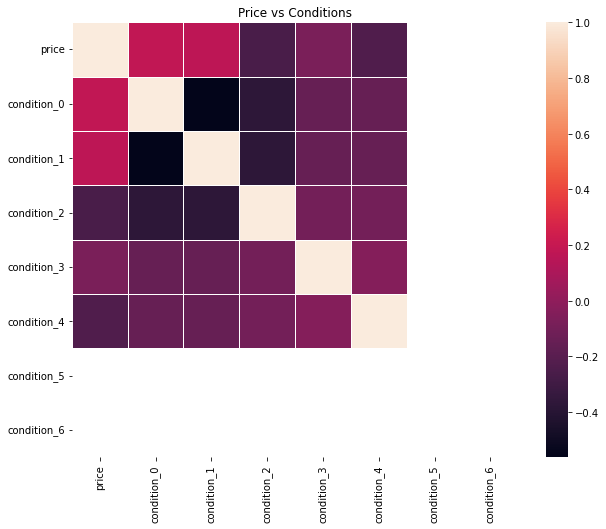

In [26]:
df_heat_condition=df_heat[["price","condition_0","condition_1","condition_2","condition_3","condition_4","condition_5","condition_6"]]
#encoded.select("price","condition_0","condition_1","condition_2","condition_3","condition_4","condition_5","condition_6").sample(False,0.0001,63).toPandas()

matrix = df_heat_condition.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(matrix, linewidth=0.5)
plt.title('Price vs Conditions')

Text(0.5, 1.0, 'Price vs Title Status')

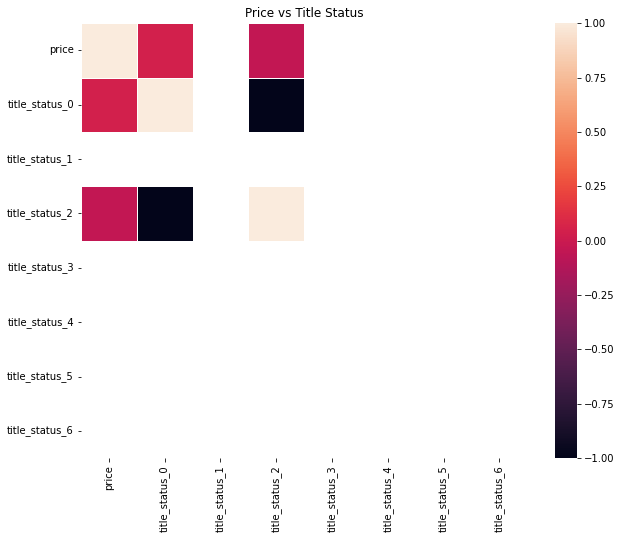

In [27]:
df_heat_title_status=df_heat[["price","title_status_0","title_status_1","title_status_2","title_status_3","title_status_4","title_status_5","title_status_6"]]
#encoded.select("price","condition_0","condition_1","condition_2","condition_3","condition_4","condition_5","condition_6").sample(False,0.0001,63).toPandas()

matrix = df_heat_title_status.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(matrix, linewidth=0.5)
plt.title('Price vs Title Status')

In [28]:
clean_carsdata.select('region', 'price', 'year', 'manufacturer', 'model', 'condition').describe().show()
clean_carsdata.select('cylinders', 'fuel', 'odometer', 'title_status', 'transmission').describe().show()
clean_carsdata.select('drive', 'size', 'type', 'county', 'state').describe().show()

+-------+--------------------+------------------+------------------+------------+--------------------+---------+
|summary|              region|             price|              year|manufacturer|               model|condition|
+-------+--------------------+------------------+------------------+------------+--------------------+---------+
|  count|              298061|            298061|            298061|      298061|              298061|   298061|
|   mean|                null|  17268.8696911035|2010.1089609173962|        null|  2028.8864353312304|     null|
| stddev|                null|13711.733852783767| 9.415662197252933|        null|   6395.786397641427|     null|
|    min|         SF bay area|              50.0|            1930.0|       acura|"1500 2wd reg cab...|excellent|
|    max|zanesville / camb...|          299991.0|            2018.0|       volvo|🔥GMC Sierra 1500...|  salvage|
+-------+--------------------+------------------+------------------+------------+----------------

+-------+------------+------+-----------------+------------+------------+
|summary|   cylinders|  fuel|         odometer|title_status|transmission|
+-------+------------+------+-----------------+------------+------------+
|  count|      298061|298061|           298061|      298061|      298061|
|   mean|        null|  null| 98105.3672972982|        null|        null|
| stddev|        null|  null|57268.74792528796|        null|        null|
|    min|10 cylinders|diesel|              0.0|       clean|   automatic|
|    max|       other| other|         250000.0|     salvage|       other|
+-------+------------+------+-----------------+------------+------------+



+-------+------+-----------+------+--------------------+--------------------+
|summary| drive|       size|  type|              county|               state|
+-------+------+-----------+------+--------------------+--------------------+
|  count|298061|     298061|298061|              298061|              298061|
|   mean|  null|       null|  null|   1455.659677419355|  1419.5743944636679|
| stddev|  null|       null|  null|  1233.6315641515878|   886.3154274754382|
|    min|   4wd|    compact|   SUV|                    |                 ...|
|    max|   rwd|sub-compact| wagon|✅ Phone 📱: (503)...|           blindspot|
+-------+------+-----------+------+--------------------+--------------------+



In [29]:
print(clean_carsdata.select("manufacturer").distinct().count())
print(clean_carsdata.select("model").distinct().count())
print(clean_carsdata.select("manufacturer","model").distinct().count())

43


25007
25511


In [30]:
indexer = StringIndexer(inputCol="manufacturer", outputCol="Index",).setHandleInvalid("skip")
indexed = indexer.fit(clean_carsdata).transform(clean_carsdata)
indexed.select("manufacturer","Index").distinct().orderBy("Index").show()

+-------------+-----+
| manufacturer|Index|
+-------------+-----+
|         ford|  0.0|
|    chevrolet|  1.0|
|       toyota|  2.0|
|        honda|  3.0|
|         jeep|  4.0|
|       nissan|  5.0|
|          gmc|  6.0|
|          bmw|  7.0|
|          ram|  8.0|
|      missing|  9.0|
|        dodge| 10.0|
|mercedes-benz| 11.0|
|       subaru| 12.0|
|      hyundai| 13.0|
|   volkswagen| 14.0|
|        lexus| 15.0|
|         audi| 16.0|
|          kia| 17.0|
|     cadillac| 18.0|
|     chrysler| 19.0|
+-------------+-----+
only showing top 20 rows



In [31]:
clean_carsdata.groupBy("condition").agg({"*": "count"}).collect()

[Row(condition='new', count(1)=451),
 Row(condition='other', count(1)=108343),
 Row(condition='excellent', count(1)=76021),
 Row(condition='salvage', count(1)=492),
 Row(condition='like new', count(1)=15205),
 Row(condition='good', count(1)=91898),
 Row(condition='fair', count(1)=5651)]

In [32]:
indexed.corr("price","Index")

-0.03573405369453014

# Save the clean dataset

In [20]:
clean_carsdata.toPandas().to_csv("sclean.csv")

NameError: name 'clean_carsdata' is not defined

# Data Modeling 

In [ ]:
#import the data file
df=pd.read_csv("sclean.csv")
df

In [ ]:
#see the data file
df.T

In [ ]:
#see the value count after dropping small values
df["price"].value_counts()

In [ ]:
len(df)

In [ ]:
#find the columns which conatains strings
for label,content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

# Turn categorical into numbers and fill missing

In [ ]:

for label,content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        #turn categories into numbers and add+1
        df[label] =pd.Categorical(content).codes+1

In [ ]:
df.info()

# Covert the csv dataframe to spark dataframe

In [ ]:
from pyspark.sql import SQLContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark_dff = sqlContext.createDataFrame(df)

# Gradient-Boosted Trees

In [ ]:
from __future__ import print_function

from pyspark.ml.regression import GBTRegressor
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

In [ ]:
assembler = VectorAssembler(inputCols=["region","year","manufacturer","model","condition","cylinders","fuel","odometer","title_status","transmission","drive","size","type","state"],outputCol="features")

In [ ]:
df1 = assembler.transform(spark_dff).select("price", "features")


In [ ]:
# split data into training data and testing data
trainTest = df1.randomSplit([0.8, 0.2], seed=2000)
trainingDF = trainTest[0]
testDF = trainTest[1]

In [ ]:
print("Training Dataset Count: " + str(trainingDF.count()))
print("Test Dataset Count: " + str(testDF.count()))


In [ ]:
#create our Model
dtr = GBTRegressor().setFeaturesCol('features').setLabelCol("price")


In [21]:
# Train the model using training data
model = dtr.fit(trainingDF)

22/05/03 16:13:24 WARN TaskSetManager: Stage 6 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:13:25 WARN TaskSetManager: Stage 7 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:13:28 WARN TaskSetManager: Stage 8 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:13:33 WARN TaskSetManager: Stage 10 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:13:37 WARN TaskSetManager: Stage 12 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:13:37 WARN TaskSetManager: Stage 14 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:13:38 WARN TaskSetManager: Stage 16 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 

22/05/03 16:14:02 WARN TaskSetManager: Stage 120 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:14:02 WARN TaskSetManager: Stage 122 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:14:03 WARN TaskSetManager: Stage 124 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:14:03 WARN TaskSetManager: Stage 126 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:14:03 WARN TaskSetManager: Stage 128 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:14:04 WARN TaskSetManager: Stage 130 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.
22/05/03 16:14:04 WARN TaskSetManager: Stage 132 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.

In [22]:
# Generate predictions using model for all features
fullPredictions = model.transform(testDF).cache()

In [23]:
# Extract the predictions and the "known" correct labels.
predictions = fullPredictions.select("prediction").rdd.map(lambda x: x[0])
labels = fullPredictions.select("price").rdd.map(lambda x: x[0])

In [24]:
# Zip them together
predictionAndLabel = predictions.zip(labels).collect()

22/05/03 16:15:55 WARN TaskSetManager: Stage 210 contains a task of very large size (4576 KiB). The maximum recommended task size is 1000 KiB.


# Predicted and actual values for each point


In [25]:
x_values=[]
y_values=[]

# Print out the predicted and actual values for each point

for prediction in predictionAndLabel:
    print(prediction)

    x_values.append(prediction[0])
    y_values.append(prediction[1])

(4727.947320389722, 62.0)
(4727.947320389722, 62.0)
(7041.22117079421, 65.0)
(7019.4072539393455, 80.0)
(5119.504932683524, 98.0)
(22688.393992001947, 99.0)
(19369.068627113407, 99.0)
(28250.117209788466, 99.0)
(28397.198420099507, 99.0)
(28250.117209788466, 99.0)
(27022.4592265617, 99.0)
(31581.816700747066, 99.0)
(28554.203700955215, 99.0)
(34373.649443505645, 99.0)
(27022.4592265617, 99.0)
(21106.220910871085, 99.0)
(9715.983794253541, 100.0)
(8059.917085478811, 100.0)
(4966.017154896962, 100.0)
(9032.494443158812, 100.0)
(16471.099933043566, 100.0)
(5261.356612546329, 101.0)
(21580.953506392303, 103.0)
(7141.891820861489, 109.0)
(7123.004018475092, 113.0)
(64281.344096192035, 115.0)
(6502.661318190905, 116.0)
(4977.756658024249, 116.0)
(6831.09762030693, 122.0)
(6563.6789342049315, 127.0)
(7302.184958491339, 129.0)
(4162.289123831991, 135.0)
(15196.481643213152, 140.0)
(7086.252756163974, 143.0)
(11871.150620510294, 144.0)
(8391.957494900862, 146.0)
(13957.042435190602, 150.0)
(114

(7170.491766294251, 3250.0)
(4615.284940959039, 3250.0)
(6551.253233407862, 3250.0)
(4740.942302828699, 3250.0)
(2950.2733761188347, 3250.0)
(5166.539138820046, 3250.0)
(7304.911529640956, 3250.0)
(6721.016097252466, 3250.0)
(13597.756696834682, 3250.0)
(3514.1081525666823, 3250.0)
(6168.220870469388, 3295.0)
(4237.143036651609, 3295.0)
(3826.8490852103923, 3299.0)
(5274.445745058346, 3300.0)
(7242.143283580926, 3300.0)
(6080.911227341636, 3300.0)
(7294.271966576148, 3300.0)
(3905.156962465442, 3300.0)
(4116.41680100443, 3300.0)
(6191.202805940581, 3300.0)
(4289.188180107523, 3300.0)
(9202.133716159407, 3300.0)
(5312.5346646279995, 3300.0)
(4640.029524412346, 3300.0)
(3811.308181354194, 3300.0)
(3502.079324469498, 3300.0)
(8063.177697288047, 3300.0)
(2036.214057165898, 3300.0)
(3940.6985037117647, 3300.0)
(18598.003072918713, 3300.0)
(9664.795021527561, 3300.0)
(6333.107838050796, 3300.0)
(4677.092422474015, 3350.0)
(4878.697805819376, 3350.0)
(4340.465476367613, 3350.0)
(7837.44937242

(14122.883453386283, 4995.0)
(14889.414490037972, 4995.0)
(7520.691402832976, 4995.0)
(5556.115277569498, 4995.0)
(10843.482060200477, 4995.0)
(2672.3191273390485, 4995.0)
(9744.279642011381, 4995.0)
(5778.261463198946, 4995.0)
(5663.603327394562, 4995.0)
(2972.5317590893064, 4995.0)
(6945.618976816697, 4995.0)
(8436.023046149607, 4995.0)
(4790.130968379247, 4995.0)
(4720.902018141308, 4995.0)
(14889.414490037972, 4995.0)
(11532.841172661678, 4995.0)
(11144.436856741202, 4995.0)
(14889.414490037972, 4995.0)
(8437.478854483412, 4995.0)
(4276.570337070062, 4995.0)
(8634.229955546321, 4995.0)
(4281.4030683393585, 4995.0)
(4503.228354444036, 4995.0)
(4423.984385177232, 4995.0)
(11958.97716280485, 4995.0)
(3539.9772201662, 4998.0)
(8981.349982249521, 4998.0)
(7517.951272534935, 4999.0)
(4457.581700168931, 4999.0)
(6763.512095583589, 4999.0)
(5018.505319976087, 4999.0)
(4377.322403133114, 4999.0)
(8045.279640871078, 4999.0)
(6194.853300746921, 4999.0)
(16845.463867862356, 4999.0)
(5004.25544

(11385.253990159355, 6495.0)
(12205.364539348699, 6495.0)
(5384.143884069885, 6495.0)
(4030.351277704632, 6495.0)
(16254.223285158387, 6495.0)
(7452.7634968271595, 6495.0)
(12775.054123401054, 6495.0)
(12367.172679434429, 6495.0)
(5954.816309909073, 6495.0)
(3966.771390581898, 6495.0)
(6451.884461704477, 6495.0)
(6362.880640271958, 6495.0)
(5580.7387895012735, 6495.0)
(5580.7387895012735, 6495.0)
(8637.08974588696, 6495.0)
(10577.34887071697, 6495.0)
(6493.889809300208, 6495.0)
(7168.712697818103, 6495.0)
(7023.4730282375795, 6495.0)
(6936.423314914608, 6495.0)
(6035.351028476232, 6495.0)
(5152.376684725914, 6495.0)
(9121.535792395374, 6495.0)
(4507.311792230073, 6495.0)
(13330.889584722503, 6495.0)
(6280.842714898202, 6495.0)
(6150.42837355363, 6495.0)
(6321.643789760795, 6495.0)
(6742.797671580447, 6495.0)
(12775.054123401054, 6495.0)
(11678.498770846998, 6495.0)
(4292.185231745021, 6495.0)
(12307.86893100588, 6498.0)
(13843.63701161993, 6499.0)
(7608.333769238463, 6499.0)
(8316.0623

(15536.517624501015, 7955.0)
(12136.761919227578, 7967.0)
(6641.879750158443, 7975.0)
(4485.4831745420615, 7975.0)
(7649.748679034382, 7975.0)
(6303.718852638154, 7975.0)
(10334.099345364048, 7975.0)
(10631.830686439409, 7980.0)
(7770.0734939014055, 7982.0)
(9352.969161267483, 7984.0)
(11451.978766155073, 7985.0)
(8328.53423661276, 7986.0)
(7107.931855413584, 7988.0)
(13944.58759833632, 7988.0)
(7178.51779113359, 7988.0)
(14449.941622555638, 7988.0)
(15863.219357950977, 7988.0)
(6646.994850807394, 7988.0)
(6767.774259802583, 7989.0)
(12847.949513565667, 7990.0)
(4490.58743925469, 7990.0)
(6248.69732762926, 7990.0)
(6238.1612730926845, 7990.0)
(10478.956822369506, 7990.0)
(14727.888945112998, 7990.0)
(5480.28800632886, 7990.0)
(6584.418129715902, 7990.0)
(4990.900318425791, 7990.0)
(10840.467891060951, 7990.0)
(8988.253767132232, 7991.0)
(8039.748580990223, 7993.0)
(9147.694800376414, 7995.0)
(12117.082279869128, 7995.0)
(10230.001390705465, 7995.0)
(8911.986805748129, 7995.0)
(7811.695

(12326.504005000726, 9977.0)
(7061.939372646019, 9977.0)
(7554.556644439881, 9977.0)
(5116.559160620009, 9977.0)
(13243.511768654618, 9980.0)
(7669.601715534842, 9980.0)
(10373.705311556796, 9980.0)
(7569.941991795927, 9985.0)
(23734.787626927908, 9985.0)
(9711.233286278773, 9986.0)
(15377.650822364465, 9988.0)
(6165.250370025938, 9988.0)
(9071.263326054821, 9988.0)
(8607.083697173555, 9988.0)
(8043.669854152535, 9988.0)
(15047.490243726777, 9988.0)
(6991.234007832324, 9988.0)
(8985.07728871558, 9988.0)
(11519.54486342694, 9988.0)
(13128.545392249338, 9988.0)
(14306.572900900652, 9989.0)
(8460.259095957028, 9990.0)
(13676.60497123495, 9990.0)
(8853.876423189387, 9990.0)
(14992.802243862277, 9990.0)
(5781.970030485568, 9990.0)
(7721.484494358801, 9990.0)
(9033.148558117477, 9990.0)
(11610.732222234663, 9990.0)
(14620.519334433448, 9990.0)
(6156.104293312935, 9990.0)
(10779.976160793203, 9990.0)
(6156.104293312935, 9990.0)
(16081.91127520168, 9990.0)
(9254.170586644857, 9990.0)
(7831.621

(14759.274198027837, 12000.0)
(11786.895426691077, 12000.0)
(8964.5530786704, 12000.0)
(10384.212116045288, 12000.0)
(14976.63451043614, 12000.0)
(22979.790566928597, 12000.0)
(12252.943901917584, 12000.0)
(10967.175179518244, 12000.0)
(9613.591163524035, 12000.0)
(18262.68049166461, 12000.0)
(24740.296997567148, 12080.0)
(11674.450740451191, 12099.0)
(10120.804773665539, 12100.0)
(24178.745040394726, 12158.0)
(12086.770480408328, 12180.0)
(23050.923743858682, 12200.0)
(16564.234664724707, 12200.0)
(12575.237272668157, 12250.0)
(7578.015902079032, 12280.0)
(14801.672976606176, 12288.0)
(8563.911009412106, 12288.0)
(5580.7387895012735, 12295.0)
(16196.802699801543, 12300.0)
(30994.67116278689, 12345.0)
(30994.67116278689, 12345.0)
(13029.088088677712, 12388.0)
(16013.728774929228, 12397.0)
(15613.541030142045, 12399.0)
(12501.986510655473, 12399.0)
(15986.477295969604, 12400.0)
(12109.304834849041, 12400.0)
(22911.418520465435, 12409.0)
(12637.80284061487, 12450.0)
(7856.041852844741, 1

(15751.620309327034, 15480.0)
(11242.248066311538, 15485.0)
(9853.1892216667, 15488.0)
(16913.10790279643, 15494.0)
(17420.123401526827, 15495.0)
(20020.203566552762, 15495.0)
(13774.775798515186, 15495.0)
(11234.558536354572, 15495.0)
(13288.432203829812, 15495.0)
(23676.342269094042, 15495.0)
(19379.617263498007, 15495.0)
(15712.42180878769, 15497.0)
(10555.534054148955, 15498.0)
(15373.995857181282, 15499.0)
(13289.591600589745, 15499.0)
(13564.617388171982, 15499.0)
(19904.38101392237, 15499.0)
(23897.33910060771, 15499.0)
(18918.176320737202, 15499.0)
(24659.305236326763, 15499.0)
(12828.159865430342, 15499.0)
(11952.937653893938, 15499.0)
(12553.070087605347, 15499.0)
(16976.84886005811, 15500.0)
(20089.36080386422, 15500.0)
(11162.376310894897, 15500.0)
(15746.932441016936, 15500.0)
(28883.678964634324, 15500.0)
(17575.00909075621, 15500.0)
(19028.522558945973, 15500.0)
(15244.511366578365, 15500.0)
(20845.90619725523, 15500.0)
(9226.22218336777, 15500.0)
(21874.84210351601, 155

(17982.522625059668, 18800.0)
(14530.680542823897, 18810.0)
(18624.594868553446, 18840.0)
(26406.419109631603, 18843.0)
(27772.339345375225, 18850.0)
(24248.21061776755, 18850.0)
(25085.854214146788, 18851.0)
(22496.560902346002, 18852.0)
(26934.281209932724, 18875.0)
(30235.510229543495, 18880.0)
(12191.691883837388, 18887.0)
(26635.449511054747, 18888.0)
(23048.22627266776, 18894.0)
(23663.562849041013, 18895.0)
(19030.529671694047, 18899.0)
(10251.13768300513, 18899.0)
(18554.596468621923, 18900.0)
(16794.227340163518, 18900.0)
(16430.229682711804, 18900.0)
(16165.34555808474, 18900.0)
(10126.537960636526, 18900.0)
(18846.634522663368, 18900.0)
(25273.236025112263, 18900.0)
(20273.73015176234, 18900.0)
(15614.29222119599, 18900.0)
(30643.774757291172, 18900.0)
(19558.33244012293, 18900.0)
(16645.982984728827, 18900.0)
(28385.23727048256, 18900.0)
(18332.542138086457, 18900.0)
(14873.719834218888, 18900.0)
(16948.319523386133, 18900.0)
(11011.240781142023, 18900.0)
(16742.02658708307

(19607.06636338407, 22590.0)
(34001.33464883013, 22590.0)
(23795.713542401074, 22590.0)
(17004.509410495262, 22590.0)
(34001.33464883013, 22590.0)
(20450.121778852386, 22590.0)
(23010.24657727631, 22590.0)
(23010.24657727631, 22590.0)
(26475.042007638203, 22590.0)
(33336.090745550726, 22590.0)
(23010.24657727631, 22590.0)
(34001.33464883013, 22590.0)
(15904.363287347336, 22590.0)
(22661.550844879053, 22590.0)
(23450.035331877087, 22590.0)
(23010.24657727631, 22590.0)
(20023.477263891833, 22595.0)
(20378.023420452966, 22599.0)
(16590.29118232948, 22600.0)
(22372.84301965506, 22612.0)
(34021.71475496032, 22615.0)
(28323.435688989455, 22628.0)
(25364.453903597383, 22695.0)
(25435.016526090134, 22711.0)
(30723.2614245623, 22750.0)
(22172.73500283304, 22750.0)
(13322.264699298747, 22750.0)
(28437.463842691657, 22756.0)
(22189.16542997096, 22763.0)
(17810.981082800714, 22777.0)
(17131.388155527493, 22785.0)
(21164.42969748064, 22788.0)
(30187.138704226516, 22795.0)
(15609.935394252187, 22798

(22186.40715720157, 26590.0)
(20368.62715975553, 26590.0)
(28997.829455565614, 26590.0)
(25479.47766625925, 26590.0)
(32513.63525225939, 26590.0)
(14102.563297693006, 26590.0)
(27803.45292309786, 26590.0)
(24690.476092265297, 26590.0)
(26714.753465165413, 26590.0)
(19833.74858229056, 26590.0)
(24247.04318401867, 26590.0)
(27547.227826494673, 26590.0)
(26178.525149035417, 26590.0)
(26660.28112033943, 26590.0)
(29734.61611653998, 26690.0)
(27766.46135253802, 26700.0)
(24722.365326885105, 26700.0)
(9569.115688091026, 26734.0)
(30542.504536048033, 26750.0)
(22612.617286057357, 26768.0)
(9392.21077916487, 26777.0)
(17664.665374616092, 26777.0)
(36246.30938530568, 26780.0)
(24087.574693319875, 26799.0)
(25425.16024057477, 26890.0)
(34131.893999191336, 26895.0)
(28559.21280761501, 26900.0)
(31571.78963193925, 26900.0)
(22026.647464962545, 26900.0)
(27215.681108113855, 26900.0)
(21210.606842590365, 26900.0)
(20702.599686988364, 26900.0)
(31571.78963193925, 26900.0)
(14519.329390135616, 26900.0

(31498.849163127674, 30990.0)
(32986.00121491595, 30990.0)
(32305.083767431854, 30990.0)
(33119.834089412536, 30990.0)
(34382.203812530344, 30990.0)
(30616.520182473752, 30990.0)
(27082.99318051877, 30990.0)
(31035.303834884668, 30990.0)
(32393.49594993944, 30990.0)
(27082.99318051877, 30990.0)
(35446.90219546183, 30990.0)
(29950.722887873722, 30990.0)
(30876.617584105323, 30990.0)
(29384.547676792383, 30990.0)
(29718.75870384564, 30990.0)
(23574.814091608227, 30990.0)
(21763.729165149398, 30990.0)
(33903.83034145222, 30990.0)
(39633.96345122213, 30990.0)
(31035.303834884668, 30990.0)
(29721.403088843224, 30990.0)
(35446.90219546183, 30990.0)
(31836.147763085424, 30990.0)
(28223.23680792225, 30991.0)
(38037.574654228185, 30991.0)
(32834.0932655141, 30995.0)
(44410.62798119213, 30995.0)
(32650.87118162157, 30995.0)
(17879.586128352694, 30995.0)
(27014.146011223136, 30995.0)
(16755.35174049768, 30995.0)
(19218.704567701825, 30996.0)
(30837.653277316414, 30997.0)
(27227.27874921809, 30998

(33529.43680104966, 38999.0)
(35421.99905806058, 38999.0)
(34803.51598406746, 38999.0)
(17163.186363899993, 39000.0)
(20514.765725708563, 39000.0)
(46605.491878969566, 39000.0)
(39780.54561570886, 39000.0)
(47244.98288215043, 39111.0)
(40023.63603906821, 39250.0)
(43314.9704963275, 39255.0)
(31244.693205568085, 39337.0)
(32539.96043558962, 39337.0)
(29637.970756035596, 39450.0)
(29010.218153331007, 39482.0)
(41565.07960440189, 39495.0)
(28633.25855846418, 39499.0)
(29181.729005311594, 39500.0)
(46952.348065406135, 39500.0)
(16615.71580109438, 39500.0)
(26404.52977369797, 39500.0)
(33045.87810432634, 39500.0)
(33264.73033221786, 39500.0)
(41799.40053361022, 39500.0)
(35398.69170309899, 39500.0)
(34681.60693221473, 39590.0)
(34783.188873296574, 39590.0)
(38658.59185199109, 39590.0)
(38658.59185199109, 39590.0)
(33647.321050119965, 39590.0)
(34309.72469509158, 39590.0)
(27112.45238422068, 39590.0)
(38658.59185199109, 39590.0)
(34309.72469509158, 39590.0)
(38658.59185199109, 39590.0)
(3638

(5288.0168961288755, 1000.0)
(7314.848098631654, 1000.0)
(5681.381668424147, 1100.0)
(3770.352847678375, 1100.0)
(5378.5362224321125, 1100.0)
(5164.403735754038, 1100.0)
(4929.851739234592, 1100.0)
(7302.878790557034, 1111.0)
(5604.436722918334, 1150.0)
(15794.302444188394, 1200.0)
(2098.2150309304966, 1200.0)
(6633.497919581199, 1200.0)
(2036.214057165898, 1200.0)
(5164.434774956509, 1200.0)
(6489.02190205636, 1200.0)
(5411.101044434599, 1200.0)
(26785.46005703745, 1200.0)
(7540.772074521593, 1200.0)
(6586.419522444504, 1200.0)
(3396.9466334479093, 1200.0)
(4256.630755255689, 1200.0)
(4114.412722357812, 1200.0)
(4611.283408991291, 1200.0)
(13654.192298398022, 1200.0)
(13584.190868335363, 1200.0)
(8007.490647054107, 1200.0)
(3081.37966620354, 1200.0)
(16961.807453697646, 1234.0)
(6947.603755535127, 1249.0)
(4227.814959220537, 1250.0)
(6195.430974273876, 1250.0)
(4120.4693687083845, 1250.0)
(4115.316179443335, 1250.0)
(4846.3226872442265, 1275.0)
(4139.2925619030475, 1294.0)
(2585.66648

(4336.415730096101, 3995.0)
(3983.460558174367, 3995.0)
(6360.581924205949, 3995.0)
(6928.432996209792, 3995.0)
(3068.073881371605, 3995.0)
(5438.6631866754105, 3995.0)
(12279.3658461347, 3995.0)
(5002.544729417812, 3995.0)
(3022.7440588669956, 3995.0)
(5838.822177785176, 3995.0)
(12418.129448034124, 3995.0)
(19633.60239415981, 3995.0)
(7687.854919956607, 3995.0)
(5630.5961127506425, 3996.0)
(7420.254165675577, 3999.0)
(6299.707830212438, 3999.0)
(4943.047810065422, 3999.0)
(4872.639054524549, 3999.0)
(5943.948140529503, 3999.0)
(13171.996835469246, 3999.0)
(2458.595938727255, 3999.0)
(6554.415027906578, 3999.0)
(12918.674237135749, 3999.0)
(7998.45963470295, 3999.0)
(8083.80190216355, 3999.0)
(7344.958026612611, 3999.0)
(5347.032752029432, 3999.0)
(5304.330407273966, 3999.0)
(3081.4332699779557, 3999.0)
(4292.185231745021, 3999.0)
(6676.216055178569, 3999.0)
(7418.085320179294, 3999.0)
(6956.642587259289, 3999.0)
(6831.188854874094, 3999.0)
(5436.511877582592, 3999.0)
(3491.4226784927

(4056.9791086775267, 5499.0)
(4483.031072690732, 5499.0)
(7904.109539003458, 5499.0)
(7732.026514293703, 5499.0)
(10579.136286922892, 5499.0)
(11878.936347107936, 5499.0)
(7069.489711720232, 5499.0)
(4281.4030683393585, 5499.0)
(6853.546248938365, 5499.0)
(4413.406555739518, 5499.0)
(2886.4687565095073, 5499.0)
(7934.357811241741, 5499.0)
(5235.287147601402, 5499.0)
(19934.565808593634, 5499.0)
(5958.097289926776, 5499.0)
(6150.42837355363, 5500.0)
(13321.45457535836, 5500.0)
(7713.039002583479, 5500.0)
(10583.879667995208, 5500.0)
(8743.714913238837, 5500.0)
(8986.143640032697, 5500.0)
(9274.569899990453, 5500.0)
(4837.695367143942, 5500.0)
(5116.559160620009, 5500.0)
(14944.336634632678, 5500.0)
(4986.106472387237, 5500.0)
(7889.151600443166, 5500.0)
(7317.885848982913, 5500.0)
(3814.5457249660894, 5500.0)
(8468.573202236197, 5500.0)
(8370.128809080126, 5500.0)
(8912.91055134847, 5500.0)
(9494.93755577799, 5500.0)
(6132.011365974773, 5500.0)
(6047.361838071278, 5500.0)
(12310.7267655

(3427.44462140186, 6999.0)
(12134.912382125449, 6999.0)
(6852.868693476251, 6999.0)
(8102.088072660507, 6999.0)
(7451.071967733017, 6999.0)
(13062.028703087497, 6999.0)
(7117.9410519865905, 6999.0)
(8088.4442111545295, 6999.0)
(8027.815408603315, 6999.0)
(6810.47425048544, 6999.0)
(9137.388043173127, 6999.0)
(8278.61708301462, 6999.0)
(6995.135473159359, 6999.0)
(8514.847209034615, 6999.0)
(11627.327243305675, 6999.0)
(4922.641342776384, 6999.0)
(8964.899760411465, 6999.0)
(10133.584482957063, 6999.0)
(5402.847284677008, 6999.0)
(8532.128157973299, 6999.0)
(6302.320472864045, 6999.0)
(8517.271090313121, 6999.0)
(6473.484447105003, 6999.0)
(20394.094388945625, 6999.0)
(12686.325210545754, 6999.0)
(3272.123838991169, 6999.0)
(9792.19741916966, 6999.0)
(4522.225734013501, 6999.0)
(7755.090928637957, 6999.0)
(6438.561252249563, 6999.0)
(7451.071967733017, 6999.0)
(3623.3003560965417, 6999.0)
(9887.461210000389, 6999.0)
(13448.89593641823, 6999.0)
(4584.758773647054, 6999.0)
(6818.545503145

(8239.244901045642, 8999.0)
(8047.88916551308, 8999.0)
(6646.363278778408, 8999.0)
(7491.419240245382, 8999.0)
(7448.583875842397, 8999.0)
(7709.841530750964, 8999.0)
(7789.805625878878, 8999.0)
(8077.548036172791, 8999.0)
(7374.397105573835, 8999.0)
(12767.459340384428, 8999.0)
(8731.554770746643, 8999.0)
(7523.975425983493, 8999.0)
(10993.869652595135, 8999.0)
(9902.467237039902, 8999.0)
(8974.234089529766, 8999.0)
(13737.568255423443, 8999.0)
(7466.329939803715, 8999.0)
(6091.185361062449, 8999.0)
(12723.763634522053, 9000.0)
(12914.962399069878, 9000.0)
(5502.28583055243, 9000.0)
(9491.981140024433, 9000.0)
(6794.566068690412, 9000.0)
(8665.941914842737, 9000.0)
(7296.984749738776, 9000.0)
(5166.168308664201, 9000.0)
(14093.12716261708, 9000.0)
(9732.622475523116, 9000.0)
(4534.949704381748, 9000.0)
(7497.126367558851, 9000.0)
(14585.213616275469, 9000.0)
(7345.19773849828, 9000.0)
(15360.582405180416, 9000.0)
(15564.978440378543, 9000.0)
(15176.016407285659, 9000.0)
(12211.6306845

(15236.090681045165, 11588.0)
(15236.090681045165, 11588.0)
(17226.376384643005, 11590.0)
(17074.838757749054, 11595.0)
(27467.482355101492, 11600.0)
(11201.40482004982, 11600.0)
(10672.378400449514, 11649.0)
(25905.55943940407, 11676.0)
(9941.056477934571, 11679.0)
(12984.737584199922, 11695.0)
(10414.070186285977, 11699.0)
(9283.682530806072, 11699.0)
(11366.929282681314, 11700.0)
(7028.551204975475, 11700.0)
(10002.302500813481, 11750.0)
(15876.890450158457, 11750.0)
(6923.644911140689, 11750.0)
(14286.520590208584, 11750.0)
(15186.303634531749, 11750.0)
(10720.051460322156, 11750.0)
(10820.006915786167, 11755.0)
(12575.237272668157, 11765.0)
(12575.237272668157, 11765.0)
(7752.341334681086, 11772.0)
(14642.62873304447, 11777.0)
(7504.390372306861, 11785.0)
(16036.11580864972, 11788.0)
(10926.589632069947, 11795.0)
(9155.30777419693, 11799.0)
(13280.348776717316, 11800.0)
(17227.3642725641, 11800.0)
(15934.42468224042, 11800.0)
(17227.3642725641, 11800.0)
(7100.669706731366, 11800.0

(17888.659923096304, 14590.0)
(21746.033254377733, 14590.0)
(21746.033254377733, 14590.0)
(21746.033254377733, 14590.0)
(19699.35133278002, 14590.0)
(13950.84668154126, 14590.0)
(8601.649013582753, 14590.0)
(21746.033254377733, 14590.0)
(17888.659923096304, 14590.0)
(14702.749115520002, 14590.0)
(22937.811750544217, 14590.0)
(10246.088966098885, 14590.0)
(19825.104985208494, 14590.0)
(21051.9601355866, 14590.0)
(15429.121540667698, 14590.0)
(13170.23252294027, 14599.0)
(15676.898800855339, 14599.0)
(14096.559604382115, 14599.0)
(12828.159865430342, 14600.0)
(17044.976595488894, 14600.0)
(10410.371294815988, 14600.0)
(18022.608084424315, 14600.0)
(20078.412768300255, 14653.0)
(13157.8686924962, 14662.0)
(13928.202973709038, 14671.0)
(22971.803203552197, 14671.0)
(15574.785456690952, 14688.0)
(15114.202219459175, 14697.0)
(27806.095243648895, 14699.0)
(16397.840579374675, 14700.0)
(14559.660799289137, 14700.0)
(14202.008291663338, 14700.0)
(16190.036318422444, 14700.0)
(22445.85972482038

(12356.060150257508, 17500.0)
(7571.108833639715, 17500.0)
(14741.25123196936, 17500.0)
(13046.523834232468, 17500.0)
(16067.955063794256, 17500.0)
(16586.175115793012, 17500.0)
(7489.7585270177215, 17500.0)
(29655.623334504216, 17500.0)
(19200.694353188712, 17500.0)
(24522.693087432, 17500.0)
(17035.443167954858, 17500.0)
(9713.468933439954, 17500.0)
(18377.202663920416, 17500.0)
(16220.564344477209, 17500.0)
(11325.189938352443, 17500.0)
(16614.814575254553, 17500.0)
(16614.814575254553, 17500.0)
(14663.145352274603, 17500.0)
(30939.228037664405, 17500.0)
(9776.379951657289, 17500.0)
(14741.25123196936, 17500.0)
(15513.971553064343, 17500.0)
(20319.854901530005, 17519.0)
(15869.554348570015, 17527.0)
(24387.89727317476, 17550.0)
(24596.38016005558, 17551.0)
(25247.46427645954, 17577.0)
(21940.536186479454, 17577.0)
(13243.444782959485, 17590.0)
(16380.362053830877, 17590.0)
(13984.776931512231, 17590.0)
(18417.214107342366, 17590.0)
(16726.631093667398, 17590.0)
(19832.670922929607, 

(21333.73047699255, 19995.0)
(19330.349323709503, 19995.0)
(18616.88892346842, 19995.0)
(18047.169727490924, 19995.0)
(9985.496333119387, 19995.0)
(10210.67296393818, 19995.0)
(10210.67296393818, 19995.0)
(15953.197247166709, 19995.0)
(16049.274318951419, 19995.0)
(30920.825411555434, 19995.0)
(15481.512932704543, 19995.0)
(17900.413346417987, 19995.0)
(20658.134336424133, 19995.0)
(19690.399975168515, 19995.0)
(27178.00986409006, 19995.0)
(17573.08008449482, 19995.0)
(19195.702720595807, 19995.0)
(11796.880639351719, 19995.0)
(21790.344895305534, 19995.0)
(17066.75808740313, 19995.0)
(29076.898127663902, 19995.0)
(34969.35739677651, 19995.0)
(18502.178326577894, 19995.0)
(11134.87044613965, 19995.0)
(20123.349423140702, 19995.0)
(31041.090915657845, 19995.0)
(21219.59592448645, 19995.0)
(20559.179036222464, 19995.0)
(18079.73809927792, 19995.0)
(19267.712649399266, 19995.0)
(26346.460732648557, 19995.0)
(15665.315290241484, 19995.0)
(12655.182577448291, 19995.0)
(29005.0225972435, 199

(30979.717257721783, 24900.0)
(25290.920350521963, 24900.0)
(18731.977880901726, 24900.0)
(17454.756839836806, 24900.0)
(14058.27479009314, 24900.0)
(16404.83054904303, 24900.0)
(20100.36530212245, 24900.0)
(24288.534847433482, 24900.0)
(12205.364539348699, 24900.0)
(17550.58452721008, 24900.0)
(20547.205965490586, 24900.0)
(33573.4116753127, 24900.0)
(35257.31795237298, 24900.0)
(15524.966120555167, 24900.0)
(17131.36900642069, 24901.0)
(27025.28040547315, 24944.0)
(25694.02906247573, 24944.0)
(19161.551132736866, 24950.0)
(22764.19504746952, 24950.0)
(25107.312071722474, 24950.0)
(20001.59820545917, 24950.0)
(20501.679961767783, 24950.0)
(25174.781372145088, 24950.0)
(25174.781372145088, 24950.0)
(16964.535654190608, 24959.0)
(27231.984030194875, 24971.0)
(26765.198573056907, 24975.0)
(31095.97581582772, 24977.0)
(14665.46565844321, 24977.0)
(20609.77611061739, 24980.0)
(17273.038189552928, 24985.0)
(17273.038189552928, 24985.0)
(18615.079056782797, 24985.0)
(16607.575018957006, 2498

(27251.057827811223, 29590.0)
(30408.777200000077, 29590.0)
(26553.57507251914, 29590.0)
(31035.303834884668, 29590.0)
(30813.424758841607, 29590.0)
(26553.57507251914, 29590.0)
(26553.57507251914, 29590.0)
(23310.05011962897, 29590.0)
(27545.285151509812, 29590.0)
(24437.382900668126, 29677.0)
(24467.048870686336, 29700.0)
(25775.749779739024, 29700.0)
(22437.258993945776, 29715.0)
(24885.218560112873, 29740.0)
(24385.608287701838, 29742.0)
(21195.420232342887, 29750.0)
(33842.17377922712, 29750.0)
(26111.45470776183, 29753.0)
(20848.324529024987, 29781.0)
(17021.225676199378, 29785.0)
(23258.32296339558, 29788.0)
(26235.312534284818, 29789.0)
(26678.493681089345, 29791.0)
(29718.893407593914, 29800.0)
(29733.64259668641, 29800.0)
(20536.84250382475, 29850.0)
(13979.487227469477, 29850.0)
(19912.334369101674, 29876.0)
(29649.876700341672, 29895.0)
(29535.389733673288, 29900.0)
(29020.31578992544, 29900.0)
(12964.679545809962, 29900.0)
(29917.164678503315, 29900.0)
(17665.750462302574,

(23074.47476063661, 33988.0)
(36533.08702421064, 33990.0)
(32013.321068297795, 33990.0)
(38730.019580036096, 33990.0)
(32823.681612853376, 33990.0)
(35652.91998512048, 33990.0)
(40362.612735601644, 33990.0)
(23184.989012805454, 33990.0)
(38648.35342913045, 33990.0)
(38295.84118668016, 33990.0)
(36698.336374000864, 33990.0)
(34938.218563327086, 33990.0)
(33318.963810699264, 33990.0)
(33318.963810699264, 33990.0)
(23210.524937350503, 33990.0)
(17597.828362126158, 33990.0)
(29258.99740792455, 33990.0)
(38295.84118668016, 33990.0)
(38295.84118668016, 33990.0)
(28739.26886451801, 33990.0)
(38295.84118668016, 33990.0)
(36533.08702421064, 33990.0)
(33318.963810699264, 33990.0)
(18594.063647301224, 33990.0)
(38295.84118668016, 33990.0)
(32964.18321925847, 33990.0)
(29384.547676792383, 33990.0)
(29384.547676792383, 33990.0)
(27660.135390787014, 33990.0)
(37002.755668217906, 33990.0)
(39396.26119140057, 33990.0)
(32013.321068297795, 33990.0)
(18594.063647301224, 33990.0)
(36698.336374000864, 339

(51156.929666630684, 49989.0)
(40603.6915575174, 49990.0)
(47875.44093453081, 49990.0)
(40603.6915575174, 49990.0)
(33625.12286797507, 49990.0)
(41460.20818410122, 49990.0)
(41491.49007287301, 49990.0)
(43182.30272458667, 49990.0)
(45810.219303988146, 49990.0)
(40603.6915575174, 49990.0)
(31027.75118634971, 49990.0)
(40603.6915575174, 49990.0)
(41238.651412161125, 49990.0)
(35113.36206609794, 49990.0)
(25950.24403169247, 49995.0)
(39154.54505153046, 49995.0)
(43293.12774486582, 49995.0)
(44099.10954155445, 49995.0)
(43592.57011882549, 49997.0)
(43592.57011882549, 49997.0)
(38593.25254414918, 49997.0)
(43592.57011882549, 49997.0)
(18560.988489173375, 49998.0)
(45109.09311828523, 49998.0)
(35445.82750342197, 49999.0)
(51897.63238143503, 49999.0)
(39837.584994872755, 49999.0)
(36933.65788027805, 49999.0)
(46095.671083614565, 49999.0)
(35732.161660290585, 49999.0)
(46125.24459409412, 49999.0)
(46095.671083614565, 49999.0)
(10327.493761529371, 50000.0)
(14353.526412984778, 50000.0)
(35122.7

(2556.2930455866135, 2600.0)
(6971.922129867509, 2600.0)
(4600.47636286604, 2600.0)
(5808.963223457579, 2600.0)
(12438.754882529722, 2600.0)
(3662.8632870399583, 2600.0)
(10295.356992244415, 2600.0)
(5071.17803019288, 2600.0)
(5276.85514263541, 2600.0)
(2724.218344409147, 2600.0)
(1864.3044266590875, 2600.0)
(3343.9897378319943, 2600.0)
(6504.4861819146745, 2600.0)
(4620.323421134812, 2650.0)
(7207.557308555377, 2650.0)
(4858.727447172041, 2650.0)
(7618.84775214799, 2650.0)
(5593.994480715607, 2650.0)
(4163.124569384536, 2688.0)
(3313.0353645129076, 2695.0)
(4336.996086030881, 2695.0)
(3644.638700183101, 2695.0)
(4987.1498594683335, 2695.0)
(4760.626175600259, 2699.0)
(8800.922027056147, 2700.0)
(5241.603012055787, 2700.0)
(12718.364564307687, 2700.0)
(5681.918022538728, 2700.0)
(8621.44913502462, 2700.0)
(6077.961928960103, 2700.0)
(3242.391111174635, 2700.0)
(10330.211184279158, 2700.0)
(6113.544391488645, 2700.0)
(4251.527914366193, 2700.0)
(15263.106082359234, 2700.0)
(6451.8844617

(14826.346297718785, 4500.0)
(4174.392234672361, 4500.0)
(5646.298247163812, 4500.0)
(7307.5142298560495, 4500.0)
(18804.65924152113, 4500.0)
(18899.054947132732, 4500.0)
(6652.608403244138, 4500.0)
(5163.016093420628, 4500.0)
(6504.112710403358, 4500.0)
(4837.695367143942, 4500.0)
(6766.8342326578295, 4500.0)
(6670.85336803243, 4500.0)
(5254.310597260512, 4500.0)
(2262.1271273519624, 4500.0)
(5254.310597260512, 4500.0)
(3650.6562186839965, 4500.0)
(4498.999645790553, 4500.0)
(5171.775995214318, 4500.0)
(4920.522535695536, 4500.0)
(5903.672260982079, 4500.0)
(3081.4332699779557, 4500.0)
(10342.538515031365, 4500.0)
(7125.125615447607, 4500.0)
(9390.780987492231, 4500.0)
(11878.936347107936, 4500.0)
(22414.643163026758, 4500.0)
(3690.3808611611116, 4500.0)
(5655.629102604786, 4500.0)
(6587.445884251457, 4500.0)
(4174.748152800145, 4500.0)
(8385.522480795331, 4500.0)
(5538.611114661588, 4500.0)
(7009.045510950054, 4500.0)
(4999.517405419041, 4500.0)
(5005.232978375995, 4500.0)
(4765.7541

(9155.30777419693, 6000.0)
(5785.795313796651, 6000.0)
(12104.913756176287, 6000.0)
(4264.229088186846, 6000.0)
(13115.752784470407, 6000.0)
(5646.298247163812, 6000.0)
(18654.00756758533, 6000.0)
(4533.959313320005, 6000.0)
(4643.14293052876, 6000.0)
(25035.03069446654, 6000.0)
(12027.473034524433, 6000.0)
(9559.515669920871, 6000.0)
(11106.599218470637, 6000.0)
(10893.901391210757, 6000.0)
(5339.749478188924, 6000.0)
(4344.174153299748, 6065.0)
(12197.619445070493, 6150.0)
(5967.151958556317, 6170.0)
(8282.069280683887, 6175.0)
(6895.264713519158, 6195.0)
(7043.971911130771, 6199.0)
(9147.68246838531, 6199.0)
(12583.664412426087, 6199.0)
(11504.505934454626, 6200.0)
(8345.355854492878, 6200.0)
(5921.449751680498, 6200.0)
(9557.676657448457, 6200.0)
(5062.8681037879505, 6200.0)
(7594.302498562613, 6200.0)
(5208.658722705644, 6200.0)
(9603.804288645964, 6200.0)
(6013.177090767442, 6200.0)
(6013.177090767442, 6200.0)
(4679.163573764635, 6200.0)
(9340.120737719726, 6200.0)
(6729.92268589

(12287.633883762828, 7900.0)
(9286.443840793137, 7900.0)
(9137.592369700405, 7900.0)
(14044.139635759093, 7900.0)
(6839.039107140737, 7900.0)
(8875.364071979882, 7900.0)
(6550.776625600416, 7900.0)
(9799.459111558783, 7900.0)
(8505.30730322199, 7950.0)
(9775.628603010688, 7950.0)
(7253.014927850354, 7950.0)
(4725.077429884508, 7950.0)
(8451.058998907358, 7950.0)
(3902.425146234197, 7950.0)
(6176.087485679492, 7950.0)
(6251.335546204754, 7950.0)
(10246.575728342717, 7950.0)
(9162.05657595562, 7950.0)
(9817.24712311769, 7950.0)
(5584.398196840358, 7950.0)
(7726.753589435545, 7950.0)
(12636.795618491842, 7950.0)
(7597.542182192154, 7950.0)
(7797.232604578841, 7950.0)
(8526.429376150809, 7950.0)
(8420.207140589024, 7950.0)
(9451.234621649583, 7950.0)
(10569.707205663657, 7950.0)
(12256.794773053856, 7950.0)
(13224.303727659602, 7950.0)
(9445.4460277354, 7950.0)
(6626.622692892288, 7950.0)
(6502.661318190905, 7970.0)
(8852.778910965768, 7975.0)
(8852.778910965768, 7975.0)
(6737.372391681541

(12802.538529471149, 9500.0)
(14421.555271168183, 9500.0)
(8309.550159318696, 9500.0)
(6991.840464187226, 9500.0)
(13952.543579615582, 9500.0)
(13144.613689314696, 9500.0)
(10422.561627321647, 9500.0)
(15201.818327518833, 9500.0)
(6846.170538705445, 9500.0)
(6707.86974285088, 9500.0)
(8853.656642100033, 9500.0)
(7433.500527657412, 9500.0)
(22399.313591672773, 9500.0)
(4627.478495772059, 9500.0)
(5656.223225649459, 9500.0)
(9657.769365408627, 9500.0)
(9525.161170910284, 9500.0)
(6715.233881928915, 9500.0)
(7156.90976255467, 9500.0)
(14755.928338616332, 9500.0)
(9597.280137624843, 9500.0)
(8431.983095272013, 9500.0)
(12599.838984745344, 9500.0)
(9611.230801829905, 9500.0)
(8781.400754197128, 9500.0)
(13461.230615477027, 9500.0)
(9099.902121560546, 9500.0)
(12185.456323198849, 9500.0)
(9961.549365945584, 9500.0)
(7443.524911763675, 9500.0)
(9350.867184320647, 9501.0)
(9088.56653195916, 9550.0)
(8960.7356126436, 9550.0)
(6680.809184268726, 9580.0)
(6209.317207610269, 9590.0)
(11525.9076854

(8927.273128200204, 11995.0)
(16415.9964187104, 11995.0)
(11046.44219120003, 11995.0)
(14291.47522772367, 11995.0)
(15458.664698380473, 11995.0)
(15749.605874541738, 11995.0)
(11498.075052400094, 11995.0)
(14046.83027561782, 11995.0)
(10378.807282919966, 11995.0)
(13515.310572212178, 11995.0)
(9338.616156591559, 11995.0)
(10422.30841326279, 11995.0)
(12105.617829148267, 11995.0)
(9855.06737720445, 11995.0)
(14244.881474194708, 11995.0)
(11606.22510757185, 11995.0)
(17057.621947260577, 11995.0)
(8548.406025845165, 11995.0)
(16858.25475716017, 11995.0)
(13200.368589284592, 11995.0)
(21117.002531793984, 11995.0)
(11180.553034212775, 11995.0)
(9160.906516483663, 11995.0)
(13905.745388178168, 11995.0)
(14505.769689385566, 11995.0)
(15456.719315420709, 11995.0)
(13730.458099184874, 11995.0)
(12315.815151898632, 11995.0)
(14014.357852771018, 11995.0)
(15627.787721025996, 11995.0)
(9898.854112060515, 11995.0)
(23285.669247162088, 11995.0)
(9330.631686620809, 11995.0)
(12663.887549165232, 11995

(18596.137695062993, 14000.0)
(10601.34973303611, 14000.0)
(9817.758277366538, 14000.0)
(6801.440923772957, 14000.0)
(12493.663784749888, 14000.0)
(14831.467166162818, 14179.0)
(8990.650048264446, 14188.0)
(26642.51006474708, 14194.0)
(14746.509521319564, 14198.0)
(15782.081595459062, 14200.0)
(14199.142676247238, 14200.0)
(9701.540666273202, 14211.0)
(12987.65719817951, 14221.0)
(7342.937351677456, 14250.0)
(15144.1931498118, 14250.0)
(9737.896900783717, 14250.0)
(21449.2499957875, 14250.0)
(13734.514908200108, 14288.0)
(8804.068398883743, 14288.0)
(23983.06090687274, 14295.0)
(16262.154528444911, 14295.0)
(23983.06090687274, 14295.0)
(16146.847430591446, 14300.0)
(14882.293007622347, 14337.0)
(16039.597377781558, 14337.0)
(15183.00646845721, 14350.0)
(15931.307537258683, 14377.0)
(11899.751405721507, 14393.0)
(15648.186310267585, 14395.0)
(15348.23486981602, 14395.0)
(29819.898271133152, 14400.0)
(11046.44219120003, 14400.0)
(20763.054375003783, 14405.0)
(22024.71030746757, 14408.0)


(12227.98120713902, 16900.0)
(17490.36930839014, 16900.0)
(20787.055196985573, 16900.0)
(8188.370150379345, 16900.0)
(8040.225199016195, 16900.0)
(25183.2590335014, 16900.0)
(13088.189952170713, 16900.0)
(16362.79556270918, 16900.0)
(14159.95554165086, 16900.0)
(15750.121897682342, 16900.0)
(18085.45149737753, 16900.0)
(24673.18606035216, 16900.0)
(27525.166759448184, 16900.0)
(15860.8230750503, 16900.0)
(19869.731404707305, 16906.0)
(17273.61593168148, 16937.0)
(12017.604473042202, 16942.0)
(26995.785352877276, 16950.0)
(15717.34942625523, 16950.0)
(11383.322955388941, 16950.0)
(16082.853201583886, 16950.0)
(12728.263999768393, 16950.0)
(27572.919191696026, 16950.0)
(26163.521208964594, 16950.0)
(19361.506692013743, 16950.0)
(11954.53760652869, 16952.0)
(15511.764022594916, 16958.0)
(15938.817078451988, 16965.0)
(30649.650967512964, 16965.0)
(15783.919214022122, 16970.0)
(22069.980969142933, 16977.0)
(9174.746871310517, 16977.0)
(14251.651888968188, 16980.0)
(25940.31262345229, 16981.

(21617.303331262698, 19990.0)
(7099.814681567605, 19990.0)
(14740.481538621036, 19990.0)
(12998.897357114101, 19990.0)
(21345.665508070648, 19990.0)
(24531.19311153809, 19990.0)
(21792.743835662954, 19990.0)
(21743.359594774607, 19990.0)
(21718.118358862008, 19990.0)
(16901.380436497548, 19990.0)
(26837.561537792964, 19990.0)
(27601.567684859732, 19990.0)
(19327.29623234009, 19990.0)
(27601.567684859732, 19990.0)
(16088.180438730715, 19990.0)
(27601.567684859732, 19990.0)
(16471.099933043566, 19990.0)
(20349.103978589446, 19990.0)
(23552.033849408315, 19990.0)
(20036.502001072666, 19990.0)
(24531.19311153809, 19990.0)
(12585.682542595829, 19990.0)
(19486.970353082947, 19990.0)
(22105.013892157123, 19990.0)
(34115.20394860154, 19990.0)
(20748.87704610771, 19990.0)
(20349.103978589446, 19990.0)
(18463.454910480858, 19990.0)
(27601.567684859732, 19990.0)
(21104.16525541484, 19991.0)
(21282.390944179606, 19991.0)
(17203.018426152175, 19991.0)
(14381.913589178068, 19991.0)
(16645.9829847288

(17875.302047327656, 23989.0)
(10190.327796835927, 23990.0)
(28150.486199635914, 23990.0)
(28338.6652852141, 23990.0)
(22661.550844879053, 23990.0)
(21679.93051245667, 23990.0)
(28111.64644276644, 23990.0)
(24493.32930462775, 23990.0)
(20450.121778852386, 23990.0)
(28150.486199635914, 23990.0)
(24913.665329517207, 23990.0)
(30336.186624492093, 23990.0)
(24933.61825297019, 23990.0)
(23276.068332763207, 23990.0)
(33954.5177753583, 23990.0)
(29833.80505928392, 23990.0)
(20450.121778852386, 23990.0)
(28205.604541607594, 23990.0)
(15601.862472265462, 23990.0)
(25016.01302769747, 23990.0)
(23184.989012805454, 23990.0)
(21470.719784852216, 23990.0)
(21679.93051245667, 23990.0)
(25182.13125152815, 23990.0)
(25728.06889626088, 23990.0)
(23184.989012805454, 23990.0)
(23184.989012805454, 23990.0)
(20466.882600939283, 23990.0)
(30061.170616583306, 23990.0)
(22805.07863661725, 23990.0)
(28204.423558167393, 23990.0)
(26977.673557422804, 23990.0)
(30336.186624492093, 23990.0)
(16594.64281161347, 2399

(21783.559605116545, 28590.0)
(28558.001416462164, 28590.0)
(31976.526417344136, 28590.0)
(28675.792993245548, 28590.0)
(32964.18321925847, 28590.0)
(31521.844446924835, 28590.0)
(24460.981609567392, 28590.0)
(34323.28016533833, 28590.0)
(31521.844446924835, 28590.0)
(17228.600559139813, 28590.0)
(32964.18321925847, 28590.0)
(17228.600559139813, 28590.0)
(31942.353628804158, 28590.0)
(33520.906728982634, 28590.0)
(31521.844446924835, 28590.0)
(30039.865108680548, 28590.0)
(28647.44224639919, 28590.0)
(30039.865108680548, 28590.0)
(31521.844446924835, 28590.0)
(24460.981609567392, 28590.0)
(28675.792993245548, 28590.0)
(31942.353628804158, 28590.0)
(35408.301059749516, 28590.0)
(32441.270313048073, 28590.0)
(32230.697067496407, 28590.0)
(27448.33457435475, 28590.0)
(30001.66507385871, 28590.0)
(31035.303834884668, 28590.0)
(26178.525149035417, 28590.0)
(28942.25462362392, 28590.0)
(32230.697067496407, 28590.0)
(16779.832630026434, 28590.0)
(31521.844446924835, 28590.0)
(30304.6854675872

(29218.036289701708, 35590.0)
(33158.156063671704, 35590.0)
(29454.75314881241, 35590.0)
(33158.156063671704, 35590.0)
(35153.24995283992, 35590.0)
(29454.75314881241, 35590.0)
(35652.91998512048, 35590.0)
(29218.036289701708, 35590.0)
(33391.27168014526, 35590.0)
(34025.04098528617, 35590.0)
(32065.359249340316, 35590.0)
(35371.64711461368, 35590.0)
(35371.64711461368, 35590.0)
(33158.156063671704, 35590.0)
(29454.75314881241, 35590.0)
(27280.973491412944, 35590.0)
(30594.601884173004, 35590.0)
(35371.64711461368, 35590.0)
(32216.582304299754, 35590.0)
(33647.64386518211, 35590.0)
(29218.036289701708, 35590.0)
(31440.731621750296, 35590.0)
(24707.30602057615, 35590.0)
(33158.156063671704, 35590.0)
(35731.74163546746, 35590.0)
(30949.7741846369, 35590.0)
(34864.00199736685, 35590.0)
(35371.64711461368, 35590.0)
(33391.27168014526, 35590.0)
(35153.24995283992, 35590.0)
(33803.55663177964, 35590.0)
(35652.91998512048, 35590.0)
(33158.156063671704, 35590.0)
(30594.601884173004, 35590.0)
(

(57294.92468305641, 44999.0)
(30362.434307516553, 44999.0)
(51436.68539620799, 45000.0)
(24947.72988814653, 45000.0)
(18020.890874953096, 45000.0)
(43540.25510109185, 45000.0)
(18020.890874953096, 45000.0)
(45109.09311828523, 45000.0)
(25546.950081139683, 45000.0)
(38281.91943512724, 45300.0)
(35510.57852459016, 45300.0)
(31563.23592488404, 45498.0)
(42235.15699078581, 45500.0)
(34261.322311966986, 45555.0)
(44655.594225472596, 45590.0)
(35875.009502631765, 45590.0)
(32101.524104980508, 45900.0)
(15950.876318965731, 45900.0)
(40476.19531990827, 45950.0)
(43486.5811461099, 45988.0)
(40069.522325280646, 45988.0)
(36689.28244073748, 45990.0)
(39286.83706652588, 45990.0)
(29636.35576412843, 45990.0)
(39178.77726622092, 45990.0)
(22437.761135563316, 45990.0)
(48566.8258233381, 45995.0)
(15113.908769744137, 45995.0)
(44756.79254383929, 45995.0)
(34143.18997251429, 45995.0)
(26457.018046865724, 45998.0)
(39135.17423711285, 45999.0)
(38593.25254414918, 45999.0)
(34542.45768866597, 45999.0)
(39

(4134.520205354986, 2500.0)
(18103.688392305692, 2500.0)
(16645.890119524818, 2500.0)
(2738.7392352062416, 2500.0)
(3820.1567236510305, 2500.0)
(10366.117448199351, 2500.0)
(4170.004986969978, 2500.0)
(4330.476552668662, 2500.0)
(3699.4648604262793, 2500.0)
(3323.949453144603, 2500.0)
(3869.100895287423, 2500.0)
(19413.175901276616, 2500.0)
(7289.900529396706, 2500.0)
(15618.339344585553, 2500.0)
(4801.5090973384295, 2500.0)
(13525.432983487055, 2500.0)
(3824.6355512469004, 2500.0)
(12216.740752037495, 2500.0)
(4634.375454079268, 2500.0)
(4030.0004194838625, 2500.0)
(7325.8747320602815, 2500.0)
(5019.8835597214, 2500.0)
(3338.671257926167, 2500.0)
(7239.993050599058, 2500.0)
(4374.377256292749, 2500.0)
(2176.0982568522054, 2500.0)
(1441.813307820057, 2500.0)
(5188.868859449159, 2500.0)
(2670.588795138242, 2500.0)
(8766.83989903628, 2500.0)
(9942.875896954938, 2500.0)
(5263.463948818417, 2500.0)
(5927.72924485215, 2500.0)
(2967.8916794919055, 2500.0)
(8986.913939132304, 2500.0)
(3882.26

(3429.3203114743696, 4500.0)
(5646.298247163812, 4500.0)
(6841.478705298598, 4500.0)
(6373.104362001139, 4500.0)
(3601.2163230969377, 4500.0)
(7414.53422321241, 4500.0)
(4380.753999630841, 4500.0)
(4347.396437183696, 4500.0)
(6367.2256831972445, 4500.0)
(12508.41751239059, 4500.0)
(4413.403103537687, 4500.0)
(8140.983645945495, 4500.0)
(5411.036676356625, 4500.0)
(5085.811712571504, 4500.0)
(5577.538039541143, 4500.0)
(8069.718401484326, 4500.0)
(7196.689865362013, 4500.0)
(14826.346297718785, 4500.0)
(6581.674030587731, 4500.0)
(7557.690865993443, 4500.0)
(5047.963935308686, 4500.0)
(7200.690486270827, 4500.0)
(4243.6211849103, 4500.0)
(6149.401633670156, 4500.0)
(12028.538913314691, 4500.0)
(5275.072679935631, 4500.0)
(4960.310337533395, 4500.0)
(12601.324087277835, 4500.0)
(5837.241871446843, 4500.0)
(6543.160902517843, 4500.0)
(5262.8769074592965, 4500.0)
(8515.596971947667, 4500.0)
(5638.91961507652, 4500.0)
(4884.098686199669, 4500.0)
(5124.488237642094, 4500.0)
(7333.14461869708

(9098.310264534908, 6200.0)
(4394.757337632217, 6200.0)
(4318.404628305958, 6200.0)
(5480.28800632886, 6200.0)
(7187.144295012982, 6200.0)
(6959.509622091684, 6200.0)
(4793.197047806137, 6200.0)
(7037.95591736797, 6200.0)
(8860.142562914829, 6200.0)
(12637.80284061487, 6200.0)
(6657.585081283586, 6200.0)
(6787.385626377521, 6200.0)
(4186.954381035679, 6200.0)
(11510.701727662225, 6200.0)
(8541.802214655472, 6250.0)
(15302.96173564478, 6250.0)
(6617.150136694956, 6250.0)
(4214.864300438654, 6250.0)
(14528.821884470663, 6250.0)
(3959.897936643446, 6250.0)
(4479.106933944913, 6250.0)
(6676.216055178569, 6250.0)
(5878.076810878685, 6250.0)
(4002.47378825638, 6250.0)
(5768.400848909659, 6295.0)
(7280.831783599062, 6298.0)
(6595.154721186254, 6299.0)
(4219.130132610484, 6299.0)
(6612.421215851418, 6300.0)
(9963.595491828952, 6300.0)
(6846.170538705445, 6300.0)
(6267.004183397059, 6300.0)
(6991.573729500788, 6300.0)
(13460.374955329497, 6300.0)
(12575.060710842086, 6300.0)
(6670.85336803243, 

(7765.31569561296, 8000.0)
(8824.56754476843, 8000.0)
(8397.550979533515, 8000.0)
(14872.87716127277, 8000.0)
(27037.517236755117, 8000.0)
(13361.709851158246, 8000.0)
(17877.46621565629, 8000.0)
(6376.091729909109, 8000.0)
(9223.17269793597, 8000.0)
(11752.569570907992, 8000.0)
(16513.10664933441, 8000.0)
(14575.23393437547, 8000.0)
(7499.102419936522, 8000.0)
(9197.55312174332, 8000.0)
(7013.973516057165, 8000.0)
(14196.589619313763, 8000.0)
(15660.013398394462, 8000.0)
(7328.958237164706, 8000.0)
(11668.962656225283, 8000.0)
(8459.109033372575, 8000.0)
(14238.212291717553, 8000.0)
(12027.473034524433, 8000.0)
(9182.083203643359, 8000.0)
(13015.559112818326, 8000.0)
(5880.20338817843, 8000.0)
(10191.56279490532, 8000.0)
(8672.382118309213, 8000.0)
(7656.664302077117, 8000.0)
(9720.959342721091, 8000.0)
(11545.410143709498, 8000.0)
(4262.320669777746, 8000.0)
(9940.058943298749, 8000.0)
(5506.2578101068975, 8000.0)
(19320.59897265357, 8000.0)
(8755.860824298537, 8000.0)
(8031.39205161

(9640.603634781493, 9999.0)
(11847.116686060712, 9999.0)
(7973.583583371292, 9999.0)
(14511.315272571515, 9999.0)
(12008.96595194426, 9999.0)
(6775.306559437549, 9999.0)
(10643.188471342608, 9999.0)
(9912.10877468167, 9999.0)
(13170.167468737756, 9999.0)
(15927.152392791853, 9999.0)
(7109.2612582456195, 9999.0)
(13295.446453996981, 9999.0)
(9784.973301894603, 9999.0)
(13744.320315482248, 9999.0)
(17932.383815429588, 9999.0)
(6831.188854874094, 9999.0)
(12575.926392980862, 9999.0)
(5867.186780355216, 9999.0)
(13702.525471025412, 9999.0)
(11905.74169607622, 9999.0)
(11816.738839890613, 9999.0)
(10605.00861540862, 9999.0)
(8591.216932431307, 9999.0)
(7896.982622967251, 9999.0)
(14396.307716336414, 9999.0)
(10815.877425171595, 9999.0)
(13392.809542923575, 9999.0)
(13939.178246329911, 9999.0)
(9231.055187446736, 9999.0)
(11484.776318098748, 9999.0)
(17944.206511290144, 9999.0)
(13641.077053568932, 9999.0)
(12768.25799801158, 9999.0)
(14727.80335250391, 9999.0)
(5382.358054727943, 9999.0)
(1

(7850.3763046602935, 12750.0)
(16212.676865976007, 12750.0)
(15427.111367272797, 12777.0)
(10796.550189515327, 12777.0)
(13042.60400965433, 12788.0)
(25833.20188256988, 12788.0)
(7441.51799548536, 12788.0)
(11435.79913829521, 12792.0)
(8620.769922123376, 12795.0)
(15256.098957642096, 12795.0)
(17205.54080180651, 12798.0)
(12919.224893057893, 12799.0)
(8345.392342612111, 12800.0)
(14260.672862013736, 12800.0)
(15393.50466955045, 12800.0)
(14452.222329386585, 12841.0)
(22951.494064652976, 12850.0)
(13149.326096710303, 12868.0)
(12402.727079323631, 12879.0)
(14711.652461729076, 12880.0)
(9493.705717073495, 12880.0)
(15170.505622968409, 12882.0)
(6323.835645940676, 12882.0)
(5433.668226273024, 12885.0)
(9595.331546683981, 12888.0)
(15911.679541879908, 12888.0)
(17759.437398565213, 12888.0)
(18412.94858948543, 12888.0)
(12744.77574806026, 12895.0)
(15393.50466955045, 12895.0)
(11853.00920788847, 12895.0)
(7022.14648865002, 12898.0)
(15039.751364258289, 12900.0)
(27213.27047600316, 12900.0)


(10817.59331967351, 15495.0)
(23672.695365699412, 15495.0)
(14498.845678823183, 15495.0)
(13122.003322149993, 15498.0)
(14416.847302115923, 15499.0)
(12553.070087605347, 15499.0)
(20999.22811514941, 15500.0)
(10442.1323375557, 15500.0)
(10444.476434934892, 15500.0)
(10147.37555416486, 15500.0)
(5751.19686916814, 15500.0)
(15059.795825556233, 15500.0)
(11328.887692442688, 15500.0)
(9148.059530184855, 15500.0)
(14516.262648890122, 15500.0)
(15832.74242247645, 15500.0)
(16626.69555080613, 15500.0)
(10829.385712870928, 15500.0)
(23490.434193196266, 15500.0)
(19388.62988134419, 15500.0)
(12637.16486242127, 15500.0)
(12655.182577448291, 15500.0)
(28698.69810621319, 15500.0)
(23134.72237057008, 15500.0)
(17360.610750920037, 15500.0)
(16962.756611324847, 15500.0)
(15180.848730208954, 15513.0)
(19557.179706813928, 15520.0)
(25569.886886717548, 15555.0)
(6875.615678142742, 15575.0)
(16898.424698130824, 15580.0)
(12959.844610723538, 15588.0)
(16764.158474950247, 15588.0)
(11788.601826443113, 1559

(26234.742077626113, 17995.0)
(21438.005261993818, 17995.0)
(10078.117004946558, 17995.0)
(18345.66878866468, 17995.0)
(16207.958491914807, 17995.0)
(17183.032699685147, 17995.0)
(20447.046665458463, 17995.0)
(15568.845521607427, 17995.0)
(10566.79895158925, 17995.0)
(21471.721410181184, 17995.0)
(11581.295825188852, 17995.0)
(14322.422930291224, 17995.0)
(12459.143616880057, 17995.0)
(12866.845918509985, 17995.0)
(15715.892258687465, 17997.0)
(11587.647950898303, 17997.0)
(14599.910669435936, 17997.0)
(17483.38379562459, 17997.0)
(16122.251718309228, 17997.0)
(16678.387207426436, 17998.0)
(15561.413702750982, 17998.0)
(22612.476570707287, 17998.0)
(13444.49218817193, 17998.0)
(25657.734984077913, 17998.0)
(13444.49218817193, 17998.0)
(13340.228126552927, 17998.0)
(15561.413702750982, 17998.0)
(8930.911302537872, 17998.0)
(17433.691905274976, 17998.0)
(20060.42094460631, 17999.0)
(18345.66878866468, 17999.0)
(17775.957985667854, 17999.0)
(19747.87813092928, 17999.0)
(14167.33968399788,

(30957.0194084009, 21900.0)
(29166.433127365257, 21900.0)
(14759.704134924183, 21900.0)
(20180.22323699829, 21900.0)
(16927.397112344348, 21900.0)
(21856.785104056646, 21900.0)
(17373.56453990145, 21900.0)
(12766.27559538439, 21900.0)
(11998.010265394369, 21900.0)
(11057.241307805125, 21900.0)
(11961.220859293131, 21900.0)
(18746.302355432585, 21900.0)
(19546.33120433348, 21900.0)
(16635.3037258824, 21900.0)
(12916.647955518685, 21901.0)
(17720.28078428798, 21905.0)
(18768.087136904007, 21919.0)
(29315.848844417884, 21921.0)
(21429.396613827088, 21942.0)
(27357.69559023852, 21945.0)
(20773.8991011637, 21950.0)
(22823.682462641962, 21950.0)
(14885.525375517309, 21950.0)
(11400.317886994619, 21950.0)
(18444.684361247284, 21950.0)
(30073.547187805507, 21950.0)
(15368.310145518739, 21950.0)
(12905.41118482544, 21950.0)
(18477.260076826773, 21969.0)
(29277.641157426096, 21977.0)
(23351.95814186172, 21980.0)
(20377.668952325723, 21980.0)
(7046.95920884309, 21980.0)
(12789.313510069529, 21980

(16952.040847160388, 25995.0)
(24409.619456602195, 25995.0)
(31098.35211111752, 25995.0)
(29122.504663099207, 25995.0)
(27947.31346764985, 25995.0)
(34152.38253039584, 25995.0)
(21227.849816827467, 25995.0)
(17795.026402786287, 25995.0)
(26142.238415416876, 25995.0)
(22604.389455022778, 25996.0)
(17664.665374616092, 25997.0)
(13311.514811600007, 25997.0)
(15681.711315875518, 25997.0)
(26248.825459629137, 25998.0)
(17269.52772258664, 25998.0)
(26400.15718542046, 25998.0)
(34345.645697782165, 25998.0)
(20426.077311918445, 25999.0)
(37257.8746844376, 25999.0)
(21175.471177477488, 25999.0)
(17726.99241963022, 25999.0)
(20362.985365389868, 25999.0)
(32834.0932655141, 25999.0)
(33073.01187784762, 25999.0)
(10786.42109345223, 25999.0)
(22440.66050289844, 25999.0)
(27374.865253112832, 25999.0)
(19888.266116213705, 25999.0)
(19784.89400257195, 25999.0)
(24596.38016005558, 26000.0)
(33877.19524669101, 26000.0)
(31513.016291206022, 26000.0)
(27525.369230525856, 26000.0)
(24722.365326885105, 26000

(35764.64893895621, 29998.0)
(15698.22178065259, 29998.0)
(35764.64893895621, 29998.0)
(15960.570113151105, 29998.0)
(26908.17014557433, 29998.0)
(26478.98319967875, 29998.0)
(17074.838757749054, 29999.0)
(12817.290980523296, 29999.0)
(25563.080406701352, 29999.0)
(36003.36637468692, 29999.0)
(22808.185416733097, 29999.0)
(12817.290980523296, 29999.0)
(31076.12659794673, 29999.0)
(24399.27086701531, 29999.0)
(31361.977251112083, 29999.0)
(27514.055570535642, 29999.0)
(21101.70110591922, 29999.0)
(26595.59303596542, 29999.0)
(15092.342826035472, 29999.0)
(20563.07425744888, 29999.0)
(16263.910699752667, 29999.0)
(36003.36637468692, 29999.0)
(39346.74542190144, 29999.0)
(29467.4805046653, 29999.0)
(31255.851207478383, 30000.0)
(31424.510751121452, 30000.0)
(9525.161170910284, 30000.0)
(31997.301158045153, 30000.0)
(18487.513101917528, 30000.0)
(25336.50766164981, 30000.0)
(23498.09519609701, 30000.0)
(17145.852400192118, 30000.0)
(34931.52025487312, 30000.0)
(18664.16854348792, 30000.0)


(34723.935183877125, 36990.0)
(36745.02138202508, 36990.0)
(37087.88641683476, 36990.0)
(36537.768789242335, 36990.0)
(35421.42662764713, 36990.0)
(19844.500209734135, 36990.0)
(39129.64658665512, 36990.0)
(35421.42662764713, 36990.0)
(28259.465613335553, 36990.0)
(35593.47827818132, 36990.0)
(36745.02138202508, 36990.0)
(18369.1508332207, 36990.0)
(39639.14894868642, 36990.0)
(28259.465613335553, 36990.0)
(25386.9096939317, 36990.0)
(35593.47827818132, 36990.0)
(35593.47827818132, 36990.0)
(36549.8710870313, 36990.0)
(31771.5812817022, 36990.0)
(28259.465613335553, 36990.0)
(34728.806605250415, 36991.0)
(21208.56113799168, 36995.0)
(29092.408906986173, 36995.0)
(16210.219585264158, 36995.0)
(30590.899101750452, 36995.0)
(30571.72258994412, 36995.0)
(28190.53207998922, 36995.0)
(35890.739494690235, 36995.0)
(30571.72258994412, 36995.0)
(25433.97347271083, 36995.0)
(28406.796062644196, 36995.0)
(28406.796062644196, 36995.0)
(37234.50321084587, 36995.0)
(39343.8084538624, 36995.0)
(37062

In [26]:
print(len(x_values))
counter =[]
for i in range(len(x_values)):
    counter.append(i)


59570


# Visualization of Predictated and Real actual values for each point


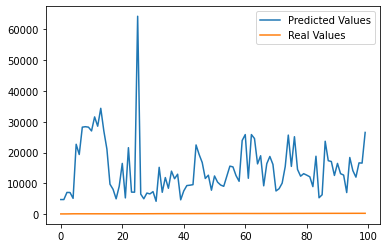

In [27]:
# create data
x = x_values[:100]
y = y_values[:100]

# plot lines
plt.plot(counter[:100], x, label="Predicted Values")
plt.plot(counter[:100], y, label="Real Values")

plt.legend()
plt.show()

# Testing Accuracy with Sklearn metrics

In [28]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(x_values, y_values))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8195.622


In [29]:
model.featureImportances

SparseVector(14, {0: 0.0002, 1: 0.2332, 2: 0.0756, 3: 0.0381, 4: 0.0312, 5: 0.1354, 6: 0.0874, 7: 0.1244, 8: 0.0261, 9: 0.0104, 10: 0.1185, 11: 0.0157, 12: 0.0585, 13: 0.0455})

### Testing model

In [36]:
sameModel = model.load("gbtmodel")

# Linear Regression

In [30]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='price', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(trainingDF)
print("Intercept: " + str(lr_model.intercept))

22/04/27 21:32:15 WARN TaskSetManager: Stage 211 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.
22/04/27 21:32:26 WARN TaskSetManager: Stage 212 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.


Intercept: -464568.6113779313


In [31]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 11064.760900
r2: 0.349209


In [32]:
trainingDF.describe().show()

22/04/27 21:32:46 WARN TaskSetManager: Stage 213 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|           238491|
|   mean|17259.11291830719|
| stddev|13715.82912986515|
|    min|             50.0|
|    max|         299991.0|
+-------+-----------------+



In [33]:
lr_predictions = lr_model.transform(testDF)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="price",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

22/04/27 21:32:49 WARN TaskSetManager: Stage 216 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.


R Squared (R2) on test data = 0.339969


In [34]:
test_result = lr_model.evaluate(testDF)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

22/04/27 21:32:54 WARN TaskSetManager: Stage 217 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.


Root Mean Squared Error (RMSE) on test data = 11126.3


In [35]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 10
objectiveHistory: [0.4999999999999998, 0.4678160170612003, 0.36625882020041506, 0.3263304172985259, 0.32557074583785794, 0.3254485987385487, 0.3254251542837728, 0.3254208876968607, 0.32542074970302337, 0.3254207138201192, 0.32542071121133]


/opt/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
22/04/27 21:32:59 WARN TaskSetManager: Stage 218 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+
|          residuals|
+-------------------+
|-14334.597850456717|
| 486.04955411411356|
|-15911.979589547089|
| -17607.42376464134|
| -16379.51706636633|
|-26824.542243156407|
| 3834.1046145901782|
| -5266.528675784357|
| -5357.040117008553|
| -16800.52964127279|
|-10244.169405495864|
| -5914.529265270219|
|-26351.885974546196|
| -8075.115457845328|
| -14506.27037383616|
| -6520.904704207671|
| -18515.40114244027|
| -14628.52954836475|
|  4679.988342802215|
|-11194.417496844893|
+-------------------+
only showing top 20 rows



# save model

In [36]:
lr_model.save(sc, "lrm_model.model")

TypeError: save() takes 2 positional arguments but 3 were given

# "prediction","price","features"

In [65]:
predictions = lr_model.transform(testDF)
predictions.select("prediction","price","features").show()

22/04/27 19:29:33 WARN TaskSetManager: Stage 220 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.


+------------------+-----+--------------------+
|        prediction|price|            features|
+------------------+-----+--------------------+
|  7180.51373694418| 62.0|[221.0,2006.0,8.0...|
|7109.9742739633075| 62.0|[352.0,2006.0,8.0...|
|  11241.4526252746| 65.0|[240.0,2002.0,30....|
|13415.171025951102| 80.0|[289.0,2004.0,17....|
|  8232.66641284083| 98.0|[297.0,2000.0,11....|
|23045.674534971768| 99.0|[204.0,2014.0,27....|
|27858.243844816112| 99.0|[204.0,2017.0,18....|
|25159.829365588143| 99.0|[204.0,2018.0,4.0...|
|28949.450006303727| 99.0|[232.0,2017.0,37....|
|25134.611333094363| 99.0|[232.0,2018.0,4.0...|
|28247.690219654527| 99.0|[232.0,2018.0,5.0...|
|26972.431240281032| 99.0|[232.0,2018.0,41....|
| 21419.70260955696| 99.0|[376.0,2016.0,14....|
| 19714.40339488443| 99.0|[376.0,2018.0,8.0...|
|28621.602420559793| 99.0|[389.0,2018.0,5.0...|
|26681.501979069726| 99.0|[389.0,2018.0,22....|
|10683.948869866494|100.0|[190.0,2013.0,39....|
| 12431.29145440855|100.0|[190.0,2014.0,

# Decision Tree 

In [68]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'price')
dt_model = dt.fit(trainingDF)
dt_predictions = dt_model.transform(testDF)
dt_evaluator = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

22/04/27 19:56:22 WARN TaskSetManager: Stage 250 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.
22/04/27 19:56:37 WARN TaskSetManager: Stage 251 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.
22/04/27 19:56:40 WARN TaskSetManager: Stage 252 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.
22/04/27 19:56:52 WARN TaskSetManager: Stage 254 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.
22/04/27 19:56:55 WARN TaskSetManager: Stage 256 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.
22/04/27 19:56:56 WARN TaskSetManager: Stage 258 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.
22/04/27 19:56:56 WARN TaskSetManager: Stage 260 contains a task of very large size (4575 KiB). The maximum recommended task size is 1000 KiB.

Root Mean Squared Error (RMSE) on test data = 9491.11


In [69]:
dt_model.featureImportances

SparseVector(14, {1: 0.4882, 2: 0.0348, 5: 0.166, 6: 0.1409, 7: 0.1329, 9: 0.0076, 10: 0.0259, 13: 0.0038})

# saving an testing the best model

In [35]:
model.save("gbtmodel")

In [ ]:
model = LinearRegressionModel.load(sc, "gbtmodel")
a = model.predict(np.array([0,0,0,0,0,0,0,8]))
print(a)